In [1]:
# Load the data
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

import torch
import torch.nn as nn
import torch.optim as optim

import skimage


############### Load climate model raw data for SST
with open('ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)


###################### Load ERA5 data

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# filter out the latitude > 60
# lat = lat[lat<=60]

# define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]

In [2]:
def data_processing(data,longitude,latitude):
    """ Process the data: statically relevant climate models (nb_runs > 3),
                            upscaling (from 0.25 to 0.5), 
                            cropping (remove latitude > 60),
                            time period focus (from 1981 until 2014)

        Args: 
            data: Dictionary of raw data (indexed by models and subdictionary indexed by runs)
            lon_size, lat_size: Integer, longitude size and latitude size
        
        Returns:
            data_processed: upscaled data
            notnan_idx, nan_idx: non nan indices and nan indices i
    """
    # first filter out the models that contain less than 3 ensemble members 
    data_processed = {}

    # record nan indices as the union of nans on each map
    nan_idx = []
    
    for idx_m,m in enumerate(data.keys()):
        
        if len(data[m].keys()) > 3:

            data_processed[m] = data[m].copy()
            
            for idx_r, r in enumerate(data[m].keys()):

                # Upscaling of raw data 
                data_processed[m][r] = skimage.transform.downscale_local_mean(data_processed[m][r][131:164,:,:],(1,2,2))
                data_processed[m][r] = data_processed[m][r][:,latitude<=60,:]

                # capture nan indices and record the union of nans
                nan_idx_tmp = list(np.where(np.isnan(data_processed[m][r][0,:,:].ravel())==True)[0])
                nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

    # define not nan indices (useful to ease the computations)
    notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

    return data_processed, notnan_idx, nan_idx

In [3]:
def compute_anomalies(data, lon_size, lat_size, nan_idx, time_period=33):
    """ Compute anomalies with respect to a given reference period.

        Args:
            - data: dictionary, preprocessed data
            - lon_size, lat_size: longitude size and latitude size
            - nan_idx: list of integers, list of nan indices in the flatten array
            - time_period: Int, time series lentgh (target period 1981-2014)
            
        Return:
            - data_anomalies: dictionary of centered (according to a specific definition) data
    """
    data_anomalies = {}

    for idx_m,m in enumerate(data.keys()):
        data_anomalies[m] = data[m].copy()

        y_tmp = np.zeros((len(data[m].keys()),time_period, lat_size*lon_size))
    
        for idx_r, r in enumerate(data[m].keys()):

            # flatten the data
            y_tmp[idx_r,:,:] = data[m][r].copy().reshape(time_period, lat_size*lon_size)

            # replace continent's grid cell values with NaNs
            y_tmp[idx_r,:,nan_idx] = float('nan')
            

        # compute mean reference
        mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
        mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)

        # center the data with respect to the given mean
        for idx_r, r in enumerate(data[m].keys()):
            
            # compute anomalies
            data_anomalies[m][r] = y_tmp[idx_r,:,:] - mean_ref_ensemble

    return data_anomalies

In [4]:
def compute_forced_response(data,lon_size, lat_size, nan_idx, time_period=33):
    """ Compute forced response.

        Args:
            - data: dictionary, preprocessed data
            - lon_size, lat_size: Integer, longitude size and latitude size
            - nan_idx: list of integers, list of nan indices in the flatten array
            - time_period: Int, time series lentgh (target period 1981-2014)
            
        Return:
            - data_anomalies: dictionary of centered (according to a specific definition) data
    """
    # compute the forced response
    data_forced_response = {}

    for idx_m,m in enumerate(data.keys()):
        
        data_forced_response[m] = data[m].copy()

        y_tmp = np.zeros((len(data[m].keys()),time_period, lat_size*lon_size))
    
        for idx_r, r in enumerate(data[m].keys()):

            # flatten the data
            y_tmp[idx_r,:,:] = data[m][r].copy().reshape(time_period, lat_size*lon_size)

            # replace continent's grid cell values with NaNs
            y_tmp[idx_r,:,nan_idx] = float('nan')
    
        
        # compute mean reference
        mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)

        # copmpute forced response (the same for each run)
        for idx_r, r in enumerate(data[m].keys()):              
            data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)

    return data_forced_response

In [5]:
def compute_variance(data,lon_size, lat_size, nan_idx, time_period=33):
    """ Compute forced response.

        Args:
            - data: dictionary, preprocessed data
            - lon_size, lat_size: Integer, longitude size and latitude size
            - nan_idx: list of integers, list of nan indices in the flatten array
            - time_period: Int, time series lentgh (target period 1981-2014)
            
        Return:
            - data_anomalies: dictionary of centered (according to a specific definition) data
    """

    # compute the variance
    variance = {}

    for idx_m,m in enumerate(data.keys()):
        
        variance[m] = {}
        arr_tmp = np.zeros((len(data[m].keys()),time_period,lon_size*lat_size))
        
        for idx_r, r in enumerate(list(data[m].keys())):
            arr_tmp[idx_r,:,:] = data[m][r]
    
        variance[m] = np.var(arr_tmp,axis=0)

    return variance

In [6]:
def merge_runs(x,y,vars):
    """ Merge runs for each model.

        Args:
            x: dictionary, anomalies
            y: dictionary, forced response
            vars: dictionary, variance
            
        Return:
            x_merged, y_merged, vars_merged: dictionaries, concatenated runs for eadch model
    """
    y_merged = {}
    x_merged = {}
    vars_merged = {}
    
    for idx_m,m in enumerate(x.keys()):
        y_merged[m] = 0
        x_merged[m] = 0
        vars_merged[m] = 0
    
        for idx_r, r in enumerate(x[m].keys()):

            if idx_r ==0:
                y_merged[m] = y[m][r]
                x_merged[m] = x[m][r]
                vars_merged[m] = vars[m]
            else:
                y_merged[m] = torch.cat([y_merged[m],y[m][r]],dim=0 )
                x_merged[m] = torch.cat([x_merged[m], x[m][r]],dim=0)  
                vars_merged[m] = torch.cat([vars_merged[m], vars[m]],dim=0)
    
    return x_merged, y_merged, vars_merged    

In [7]:
def numpy_to_torch(x,y,vars):
    x_tmp = {}
    y_tmp = {}
    vars_tmp = {}

    for idx_m,m in enumerate(x.keys()):
        x_tmp[m] = {}
        y_tmp[m] = {}
        vars_tmp[m] = {}
        
        for idx_r, r in enumerate(x[m].keys()):
            x_tmp[m][r] = torch.from_numpy(x[m][r]).to(torch.float64)
            y_tmp[m][r] = torch.from_numpy(y[m][r]).to(torch.float64)
            
        vars_tmp[m] = torch.from_numpy(vars[m]).to(torch.float64)

    return x_tmp, y_tmp, vars_tmp

In [8]:
def standardize(x,y,vars,merged=False):
    """ Standardize dataset. 

        Args:
            x: dictionary, anomalies
            y: dictionary, forced response
            vars: dictionary, variance

        Return:
        
    """
    x_tmp = {}
    y_tmp = {}
    vars_tmp = {}
    
    for idx_m,m in enumerate(x.keys()):
        x_tmp[m] = {}
        y_tmp[m] = {}
        vars_tmp[m] = {}

        if merged == False:
            for idx_r, r in enumerate(x[m].keys()):
                x_tmp[m][r] = x[m][r]/torch.sqrt(vars[m])
                y_tmp[m][r] = y[m][r]/torch.sqrt(vars[m])
        else:
            x_tmp[m] = x[m]/torch.sqrt(vars[m])
            y_tmp[m] = y[m]/torch.sqrt(vars[m])

    
    return x_tmp, y_tmp

In [9]:
data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat)
x = compute_anomalies(data_processed, lon_size, lat_size, nan_idx, time_period=33)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=33)
vars = compute_variance(x, lon_size, lat_size, nan_idx, time_period=33)

# convert numpy arrays to pytorch 
x, y, vars = numpy_to_torch(x,y,vars)

# standardize data 
x, y = standardize(x,y,vars)

# merge runs for each model
x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

/tmp/ipykernel_12120/1771696685.py:30: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
/tmp/ipykernel_12120/1771696685.py:31: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)
/tmp/ipykernel_12120/1146139563.py:32: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)
/tmp/ipykernel_12120/1146139563.py:36: RuntimeWarning: Mean of empty slice
  data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


In [10]:
def build_training_and_test_sets(m_out,x,y,vars,lon_size,lat_size,time_period=33):
    """Concatenate training sets for all models except model m. This enables to create the big matrices X and Y.

       Args:

       Return:
    """
    # merge runs for each model
    x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

    # We construct X, Y in R^{grid x runs*time steps}
    x_train = 0
    y_train = 0

    # We construct X_test, Y_test in R^{grid x runs*time steps}
    x_test = x_merged[m_out]
    y_test = y_merged[m_out]

    # Concatenate all models to build the matrix X
    training_models = []
    count_tmp = 0
    
    for idx_m,m in enumerate(x.keys()):

        if m != m_out:
            training_models.append(m)
            if count_tmp ==0:
                x_train = x_merged[m]
                y_train = y_merged[m]
                count_tmp +=1 
                
            else:
                x_train = torch.cat([x_train, x_merged[m]],dim=0)
                y_train = torch.cat([y_train, y_merged[m]],dim=0)

    return training_models, x_train, y_train, x_test, y_test

In [11]:
    m0 = 'CanESM5-1'
    
    training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets(m0,x,y,vars,lon_size,lat_size,time_period=33)

# 1- Ridge regression problem: 
# $\min_{W} \Vert Y - X W \Vert_F^2 + \lambda \Vert W \Vert_F^2$

In [12]:
def Ridge_regression_closed_form(X, Y, lambda_=1.0):
    """
    Computes the closed-form solution for reduced rank regression.
    
    Args:
        X (torch.Tensor): Predictor matrix of shape (n, p).
        Y (torch.Tensor): Response matrix of shape (n, q).
        lambda_ (scalar): Ridge penalty coefficient.
        
    Returns:
        U (torch.Tensor): Low-rank predictor coefficients of shape (p, rank).
        V (torch.Tensor): Low-rank response coefficients of shape (q, rank).
    """

    # compute Penroe Morose pseudo inverse of X^T @ X
    P = torch.linalg.inv(X.T @ X + lambda_ * torch.eye(X.shape[1]))
    
    # compute ordinary least square solution 
    W_ols = P @ X.T @ Y

    # print loss function
    loss = torch.norm(Y - X @ W_ols,p='fro')**2 + lambda_ * torch.norm(W_ols,p='fro')**2
    print("Loss function: ", loss.item())
    
    return W_ols

# 2- Ridge regression problem: 
# $\min_{W \colon \mathrm{rank}(W) \leq r} \Vert Y - X W \Vert_F^2 + \lambda \Vert W \Vert_F^2$

In [13]:
def RRR_closed_form(X, Y, rank=5.0, lambda_=1.0):
    """
    Computes the closed-form solution for reduced rank regression.
    
    Args:
        X (torch.Tensor): Predictor matrix of shape (n, p).
        Y (torch.Tensor): Response matrix of shape (n, q).
        rank (Int): Desired rank for the approximation.
        lambda_ (Float64): Ridge penalty coefficient.
        
    Returns:
        U (torch.Tensor): Low-rank predictor coefficients of shape (p, rank).
        V (torch.Tensor): Low-rank response coefficients of shape (q, rank).
    """

    # compute Penroe Morose pseudo inverse of X^T @ X
    P = torch.linalg.inv(X.T @ X + lambda_ * torch.eye(X.shape[1]))
    
    # compute ordinary least square solution 
    W_ols = P @ X.T @ Y
    
    # compute SVD decomposition of X @ W_ols
    U, S, Vh = torch.linalg.svd(X @ W_ols, full_matrices=False)
    
    # Truncate to the desired rank
    U_r = U[:, :rank]            # (p, rank)
    S_r = torch.diag(S[:rank])   # (rank, rank)
    V_r = Vh[:rank, :].T         # (q, rank)

    # compute regressor
    W_rrr = W_ols @ V_r @ V_r.T

    # print loss function
    loss = torch.norm(Y - X @ W_rrr,p='fro')**2 + lambda_ * torch.norm(W_rrr,p='fro')**2
    print("Loss function: ", loss.item())

    return W_rrr

In [14]:
# compute ridge regressor
W_ridge = Ridge_regression_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=100.0)

# compute low rank ridge regressor
r = 70
W_rrr = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=100.0)

# compute low rank ridge regressor
r = 10
W_rrr = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=100.0)

# compute low rank ridge regressor
r = 5
W_rrr = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=100.0)

Loss function:  1386798.2725697136
Loss function:  1671474.9706761625
Loss function:  2306692.376091139
Loss function:  2486475.9309012718


LOO rmse ridge regression  0.1527954707611722
LOO rmse RRR (rank= 5 )   0.1397952820350634


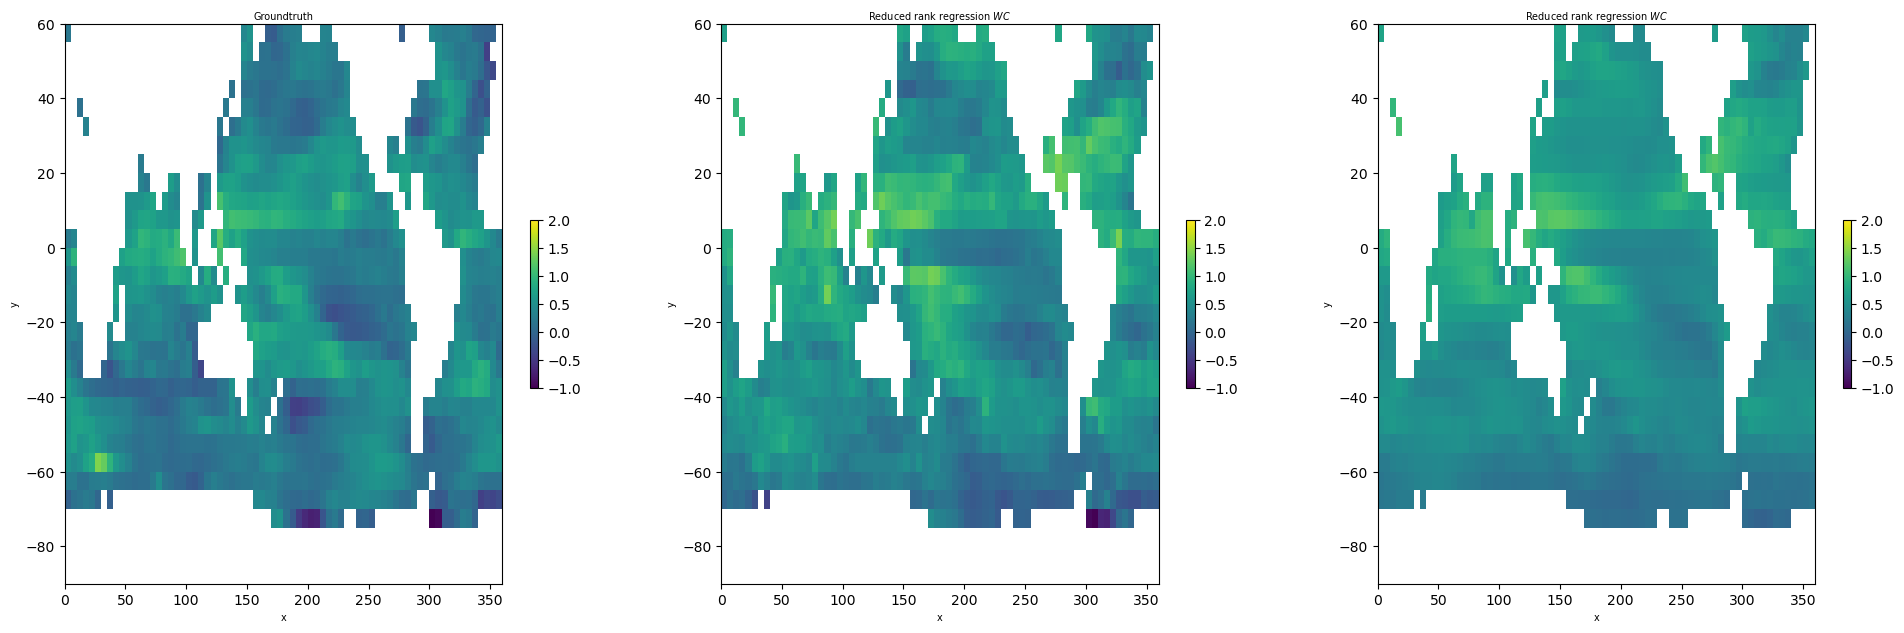

In [15]:
y_pred_ridge = torch.ones_like(x_test).to(torch.float64)
y_pred_ridge[:,nan_idx] = float('nan')
y_pred_ridge[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W_ridge.to(torch.float64)

y_pred_rrr = torch.ones_like(x_test).to(torch.float64)
y_pred_rrr[:,nan_idx] = float('nan')
y_pred_rrr[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W_rrr.to(torch.float64)

print("LOO rmse ridge regression ", torch.nanmean((y_pred_ridge - y_test)**2).item())
print("LOO rmse RRR (rank=",r,")  ", torch.nanmean((y_pred_rrr - y_test)**2).item())

y_target = y_test[:33,:]
y_target_pred_ridge = y_pred_ridge[:33,:]
y_target_pred_rrr = y_pred_rrr[:33,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred_ridge[:,nan_idx] = float('nan')
y_target_pred_rrr[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_ridge = y_target_pred_ridge[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_rrr = y_target_pred_rrr[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


plt.close('all')
fig0 = plt.figure(figsize=(24,16))           

ax0 = fig0.add_subplot(2, 3, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 3, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 3, 3)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_rrr,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

## Display predicted forced response for first run of left out climate model

In [16]:
from matplotlib import animation

time_period=33

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure(figsize=(24,16))

ax0 = fig0.add_subplot(1, 3, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 3, 2)        
ax1.set_title(r'Ridge regression', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

ax2 = fig0.add_subplot(1, 3, 3)        
ax2.set_title(r'Low rank regression', size=7,pad=3.0)
ax2.set_xlabel(r'x', size=7)
ax2.set_ylabel(r'y', size=7)

y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_rrr = y_target_pred_rrr[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_ridge = y_target_pred_ridge[0,:].detach().numpy().reshape(lat_size,lon_size)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_rrr,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred_ridge = y_target_pred_ridge[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred_rrr = y_target_pred_rrr[i,:].detach().numpy().reshape(lat_size,lon_size)

    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
    im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_rrr,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.colorbar(im2, ax=ax2, shrink=0.3)
animation.FuncAnimation(fig0, animate_maps, frames=time_period)

# Robust weight ridge regression

# $\max_{\alpha \in \Delta} \min_{W} \sum_{m} \alpha_m \Vert \Sigma^{-1/2}(Y_m - X_m W) \Vert_F^2 + \lambda \Vert W \Vert_F^2$

### Compute gradient with respect to $W$

In [17]:
def low_rank_projection(w,rank=5):
    """Compute low rank projection.

        Args:

        Returns:
    """

    # compute SVD decomposition of W
    U, S, Vh = torch.linalg.svd(w.to(torch.float64), full_matrices=False)
    
    # Truncate to the desired rank
    U_r = U[:, :rank]            # (p, rank)
    S_r = torch.diag(S[:rank])   # (rank, rank)
    V_r = Vh[:rank, :].T         # (q, rank)

    # compute regressor
    w_low_rank = U_r @ S_r @ V_r.T 

    return w_low_rank

In [18]:
def compute_gradient(models,x,y,w,notnan_idx,lambda_=1.0,mu_=1.0):
    """This function computes the gradient of ridge log-sum-exp loss with respect to W.

    Args:
        
    Returns:
        - Gradient matrix: torch.tensor d x d
    """
    res = torch.zeros(len(models), w.shape[0], w.shape[0]).to(torch.float64)
    res_sumexp = torch.zeros(len(models)).to(torch.float64)
    
    for idx_m, m in enumerate(models):
        for idx_r, r in enumerate(x[m].keys()):

            # compute -2X_{m,r}^T (Y_{m,r}^T - X_{m,r}^T W)
            res[idx_m][np.ix_(notnan_idx,notnan_idx)] -= 2*x[m][r][:,notnan_idx].T @ \
                                                        (y[m][r][:,notnan_idx] - x[m][r][:,notnan_idx] @ w[np.ix_(notnan_idx,notnan_idx)])

            # compute the exponential term
            res_sumexp[idx_m] += torch.norm(y[m][r][:,notnan_idx] - x[m][r][:,notnan_idx] @ w[np.ix_(notnan_idx,notnan_idx)], p='fro')**2
            # res_sumexp[idx_m] += torch.mean((y[m][r][:,notnan_idx] - x[m][r][:,notnan_idx] @ w[np.ix_(notnan_idx,notnan_idx)])**2)

        res[idx_m] = res[idx_m] / len(x[m].keys())
        res_sumexp[idx_m] = res_sumexp[idx_m]/(len(x[m].keys())*mu_)
    
    softmax = torch.nn.Softmax(dim=0)
    res_sumexp = softmax(res_sumexp)

    grad = torch.zeros(w.shape[0], w.shape[0]).to(torch.float64)
    for idx_m, m in enumerate(models):
        grad[np.ix_(notnan_idx,notnan_idx)] += res_sumexp[idx_m]*res[idx_m][np.ix_(notnan_idx,notnan_idx)]
        
    grad = grad + 2*lambda_* w
    
    return grad 

### Gradient descent algorithm

In [19]:
def train_robust_weight_model(models,x,y,notnan_idx,rank=5.0,lambda_=1.0,mu_=1.0,lr=0.1,nb_iterations=10):
    """This function computes the gradient of ridge log-sum-exp loss with respect to W.

       Args:
            
       Returns:
    """
    w = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
    w_old = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)

    training_loss = torch.zeros(nb_iterations)
    
    # run a simple loop
    for it in range(nb_iterations):


        # accelerate gradient descent
        if it > 1:
            w_tmp = w + ((it-2)/(it+1)) * (w - w_old)
        else:
            w_tmp = w.detach()

        # save old parameter
        w_old = w.clone().detach()

        # compute gradient
        grad = compute_gradient(models,x,y,w_tmp,notnan_idx,lambda_,mu_)

        
        # update the variable w
        w = w_tmp - lr * grad

        # low rank projection
        if rank is not None:
            w = low_rank_projection(w,rank=rank)

        # compute loss functon to check convergence 
        res = torch.zeros(len(models))
        
        for idx_m, m in enumerate(models):  
            for idx_r, r in enumerate(x[m].keys()):
                res[idx_m] += torch.sum((y[m][r][:,notnan_idx] -x[m][r][:,notnan_idx] @ w[notnan_idx,:][:,notnan_idx] )**2)
                
            res[idx_m] = res[idx_m]/len(x[m].keys())
            
        obj = mu_*torch.logsumexp((1/mu_)* res,0)
        obj += lambda_*torch.norm(w,p='fro')**2

        print("Iteration ", it,  ": Loss function : ", obj.item())
        
        training_loss[it] = obj.item()

    plt.close('all')
    plt.figure()
    plt.plot(range(nb_iterations),training_loss)
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.show()
    
    return w

### Compute weights given matrix W

In [20]:
def compute_weights(models,W,x,y,notnan_idx,lambda_=1.0,mu_=1.0):
    """Compute weights from the outcome matrix W.
        
        Args:

        Returns:
        
    """
   
    M = len(list(models))
    alpha = torch.zeros(M)
    res = torch.zeros(M)
    
    for idx_m,m in enumerate(models):
        
        for idx_r, r in enumerate(x[m].keys()):
            
            res[idx_m] += torch.sum((y[m][r][:,notnan_idx] - x[m][r][:,notnan_idx] @ W[np.ix_(notnan_idx,notnan_idx)] )**2)

        res[idx_m] = res[idx_m]/len(x[m].keys())
        alpha[idx_m] = (1/mu_)*res[idx_m]

    alpha = torch.nn.functional.softmax(alpha)
    
    # plot the model contributions
    weights = {m: alpha[idx_m].item() for idx_m,m in enumerate(models)}

    return weights

Iteration  0 : Loss function :  93973.21875
Iteration  1 : Loss function :  89432.4765625
Iteration  2 : Loss function :  86052.296875
Iteration  3 : Loss function :  82351.0859375
Iteration  4 : Loss function :  78579.3671875
Iteration  5 : Loss function :  74966.796875
Iteration  6 : Loss function :  71687.0625
Iteration  7 : Loss function :  68847.3671875
Iteration  8 : Loss function :  66492.8125
Iteration  9 : Loss function :  64616.125
Iteration  10 : Loss function :  63170.16015625
Iteration  11 : Loss function :  62081.98046875
Iteration  12 : Loss function :  61267.28125
Iteration  13 : Loss function :  60643.2734375
Iteration  14 : Loss function :  60138.3671875
Iteration  15 : Loss function :  59697.73828125
Iteration  16 : Loss function :  59285.03515625
Iteration  17 : Loss function :  58880.79296875
Iteration  18 : Loss function :  58478.85546875
Iteration  19 : Loss function :  58081.828125
Iteration  20 : Loss function :  57696.6484375
Iteration  21 : Loss function :  5

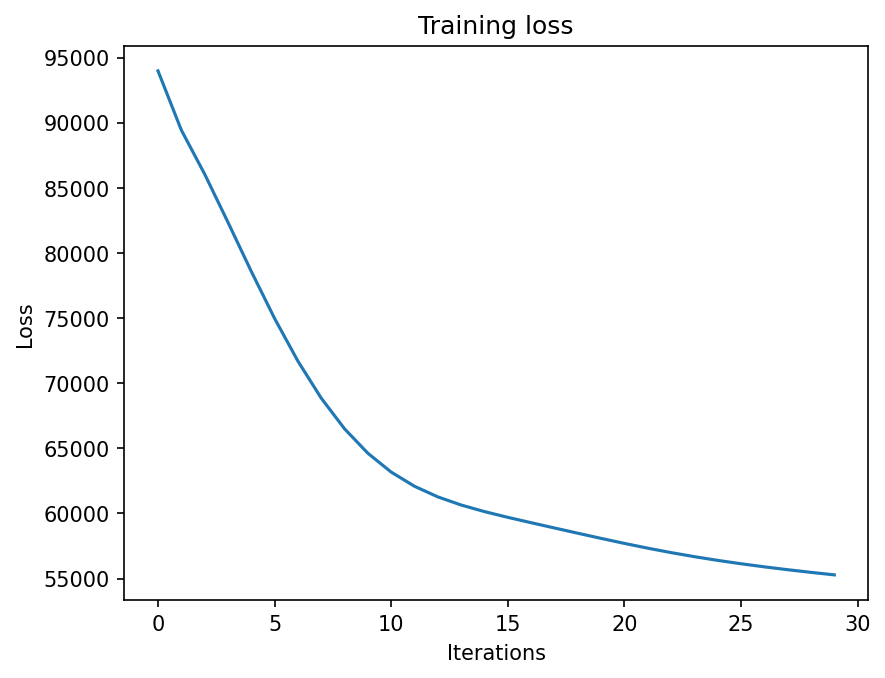

In [21]:
lambda_tmp = 100.0
mu_tmp = 1000.0

w_robust_ridge = train_robust_weight_model(training_models,x,y,notnan_idx,rank=5,lambda_=lambda_tmp,mu_=mu_tmp,nb_iterations=30,lr =0.000001)

In [22]:
# y_pred = torch.ones_like(x_test).to(torch.float64)
# y_pred[:,nan_idx] = float('nan')
# y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ w_robust_ridge[notnan_idx,:][:,notnan_idx].to(torch.float64)

# y_target = y_test[:33,:]
# y_target_pred = y_pred[:33,:]


# # display Y map for a given model m0
# time_idx = 20
# y_target[:,nan_idx] = float('nan')
# y_target_pred[:,nan_idx] = float('nan')

# y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
# y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)

# print("RMSE : ", torch.nanmean((y_test - y_pred)**2))


# plt.close('all')
# fig0 = plt.figure(figsize=(24,16))           

# ax0 = fig0.add_subplot(2, 2, 1)        
# ax0.set_title(r'Groundtruth', size=7,pad=3.0)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# ax0 = fig0.add_subplot(2, 2, 2)        
# ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# plt.show()

In [23]:
# from matplotlib import animation

# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 150  
# plt.ioff()


# plt.close('all')
# fig0 = plt.figure(figsize=(24,16))

# ax0 = fig0.add_subplot(1, 2, 1)        
# ax0.set_title(r'Groundtruth', size=7,pad=3.0)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# ax1 = fig0.add_subplot(1, 2, 2)        
# ax1.set_title(r'Robust reduced rank regression ', size=7,pad=3.0)
# ax1.set_xlabel(r'x', size=7)
# ax1.set_ylabel(r'y', size=7)

# y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
# y_to_plot_pred = y_target_pred[0,:].detach().numpy().reshape(lat_size,lon_size)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
# im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)


# def animate_maps(i):

#     y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
#     y_to_plot_pred = y_target_pred[i,:].detach().numpy().reshape(lat_size,lon_size)

#     im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
#     im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
    
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# plt.colorbar(im1, ax=ax1, shrink=0.3)
# plt.tight_layout()
# animation.FuncAnimation(fig0, animate_maps, frames=time_period)

In [24]:
# weights = compute_weights(training_models,w_robust_ridge,x,y,notnan_idx,lambda_=lambda_tmp,mu_=mu_tmp)

In [25]:
# plt.close('all')

# # plot the model contributions
# fig, ax = plt.subplots()
# models = training_models
# weights_plot = list(weights.values())

# ax.bar(training_models, weights_plot,label='Model weights')
# ax.set_ylabel(r'weights $\gamma$')
# ax.set_ylim(0.0,1.0)
# ax.set_title('cmip6 models')
# ax.legend()
# ax.set_xticklabels(models, rotation=-90)
# plt.tight_layout()
# plt.show()

# Leave-one-out procedure

In [26]:
def leave_one_out_single(model_out,x,y,vars,\
                         lon_size,lat_size,notnan_idx,\
                         lr=0.0001,nb_gradient_iterations=50,\
                         time_period=33,rank=5,\
                         lambda_=1.0,method='ridge',mu_=1.0,verbose=True):
    """Run a single iteration the leave-one-out procedure (LOO) with model_out out of the training set.

        Args:

        Returns:
    """
    W = torch.zeros(lon_size * lat_size, lon_size * lat_size).to(torch.float64)
    training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets(model_out,x,y,vars,lon_size,lat_size,time_period=33)

    # if method = ridge, then we train the ridge regression model
    if method == 'ridge':

        # compute ridge regression coefficient 
        W[np.ix_(notnan_idx,notnan_idx)] = Ridge_regression_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_)

    elif method == 'rrr':

        # compute low rank ridge regression coefficient
        W[np.ix_(notnan_idx,notnan_idx)] = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank, lambda_)

    elif method == 'robust':

        # compute low rank ridge regression coefficient
        W  = train_robust_weight_model(training_models,x,y,notnan_idx,rank,lambda_,mu_,lr =0.00001,nb_iterations=nb_gradient_iterations)

    # Predictions on test set
    y_pred = torch.ones_like(x_test).to(torch.float64)
    y_pred[:,nan_idx] = float('nan')
    y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W[np.ix_(notnan_idx,notnan_idx)].to(torch.float64)

    # Compute training errors
    y_pred_train = {}
    rmse_train = {}

    for idx_m,m in enumerate(x.keys()):
        if m != model_out:
            y_pred_train[m] = {}
            rmse_train[m] = 0.0
            for idx_r, r in enumerate(x[m].keys()):
                y_pred_train[m][r] = torch.zeros(time_period,lon_size*lat_size).to(torch.float64)
                y_pred_train[m][r][:,notnan_idx] =  x[m][r][:,notnan_idx] @ W[np.ix_(notnan_idx,notnan_idx)].to(torch.float64)
                rmse_train[m] += torch.nanmean((y_pred_train[m][r] - y[m][r])**2)
            rmse_train[m] = rmse_train[m] /len(x[m].keys())


    # compute the weights
    if method == "robust":
        weights = compute_weights(training_models,W,x,y,notnan_idx,lambda_,mu_)
    else:
        weights = (1/len(training_models)) * torch.ones(len(training_models))
    
    return W, y_pred, y_test, rmse_train

Iteration  0 : Loss function :  72344.390625
Iteration  1 : Loss function :  62999.84765625
Iteration  2 : Loss function :  62921.8671875
Iteration  3 : Loss function :  60177.76171875
Iteration  4 : Loss function :  58851.23046875
Iteration  5 : Loss function :  57595.37890625
Iteration  6 : Loss function :  56720.6484375
Iteration  7 : Loss function :  56888.3046875
Iteration  8 : Loss function :  55249.75
Iteration  9 : Loss function :  54467.91796875
Iteration  10 : Loss function :  54242.2578125
Iteration  11 : Loss function :  53810.28515625
Iteration  12 : Loss function :  53630.04296875
Iteration  13 : Loss function :  53405.91015625
Iteration  14 : Loss function :  53289.69140625
Iteration  15 : Loss function :  53165.88671875
Iteration  16 : Loss function :  53082.36328125
Iteration  17 : Loss function :  53021.2421875
Iteration  18 : Loss function :  52907.90234375
Iteration  19 : Loss function :  52880.16015625


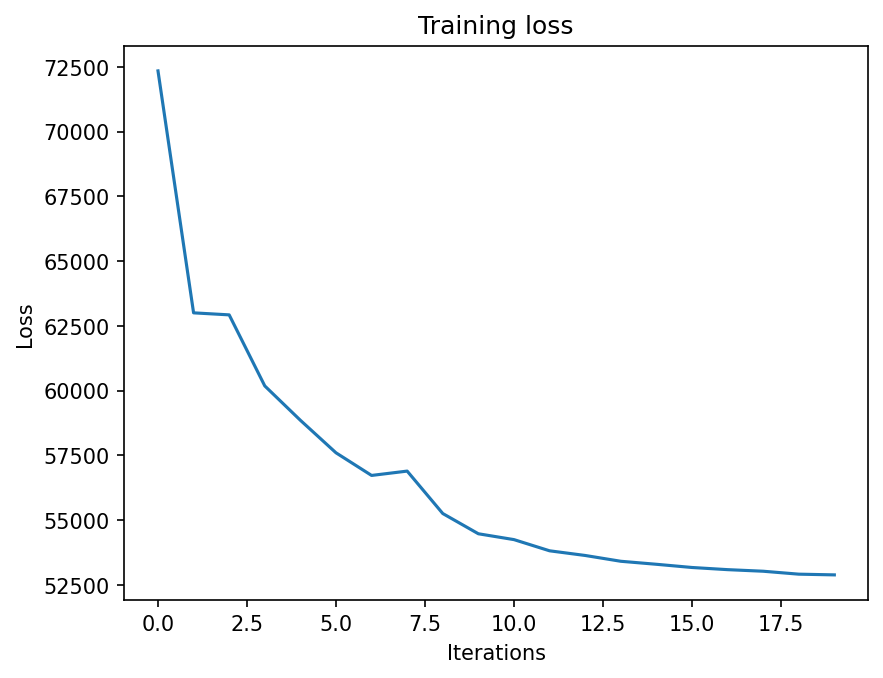

/tmp/ipykernel_12120/3923813946.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


In [27]:
W_robust, y_pred, y_test, rmse_train = leave_one_out_single(m0,x,y,vars,\
                                                              lon_size,lat_size,notnan_idx,\
                                                              lr=0.000001,nb_gradient_iterations=20,time_period=33,\
                                                              rank=5,lambda_=100.0,method='robust',mu_=1000.0,verbose=True)

In [28]:
# weights = compute_weights(training_models,W_robust,x,y,notnan_idx,lambda_=100.0,mu_=1000.0)

# print(np.sum(list(weights.values())))

# plt.close('all')

# # plot the model contributions
# fig, ax = plt.subplots()
# models = training_models
# weights_plot = list(weights.values())

# ax.bar(training_models, weights_plot,label='Model weights')
# ax.set_ylabel(r'weights $\gamma$')
# ax.set_ylim(0.0,1.0)
# ax.set_title('cmip6 models')
# ax.legend()
# ax.set_xticklabels(models, rotation=-90)
# plt.tight_layout()
# plt.show()

In [29]:
def leave_one_out_procedure(x,y,vars,\
                            lon_size,lat_size, notnan_idx,\
                            lr=0.00001,nb_gradient_iterations=20,time_period=33,\
                            rank=5,lambda_=1.0,method='ridge',mu_=1.0,verbose=True):
    """It runs the LOO procedure.

    """
    W = {}
    y_pred = {}
    y_test = {}
    
    rmse_mean = {}
    
    weights = {m: 0.0 for idx_m, m in enumerate(x.keys())}
    training_loss = {m: {} for idx_m, m in enumerate(x.keys())}
    
    for idx_m, m in enumerate(x.keys()):

        # run leave one out
        W[m], y_pred[m], y_test[m], training_loss[m] = leave_one_out_single(m,x,y,vars,\
                                                                            lon_size,lat_size,notnan_idx,\
                                                                            lr,nb_gradient_iterations,\
                                                                            time_period,rank,lambda_,method,mu_,verbose)

        
        # compute mean rmse 
        rmse_mean[m] = torch.nanmean((y_pred[m] - y_test[m])**2)        
    
        # print the rmse
        print('RMSE (mean) on model ', m, ' : ', rmse_mean[m].item())

        # list of training models
        models_tmp = list(training_loss[m].keys())

        if method == 'robust':

            # compute robust model weights
            weights[m] = compute_weights(models_tmp,W[m],x,y,notnan_idx,lambda_,mu_)

        else:

            # if we do not use the robust weight approach, then we compute uniform weights
            weights[m] = {m_tmp: 1/len(models_tmp) for m_tmp in models_tmp}
            
        # compute weight = 0.0 for climate model m 
        weights[m][m] = 0.0

    weights_tmp = torch.zeros(len(x.keys()))
    for idx_m, m in enumerate(x.keys()):
        weights_tmp +=  torch.tensor(list(weights[m].values()))

    weights_tmp = weights_tmp / (len(x.keys()))

    # Check that the sum of weights = 1
    print("Check that sum of weights ==1 : ", torch.sum(weights_tmp).item())
    
    # update the list of model to take into account
    models = list(x.keys()) 
    
    ################# plot the rmse #################
    fig, ax = plt.subplots()
    ax.bar(models, weights_tmp,label='Model weights')
    ax.set_ylabel(r'$\alpha^m$')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    plt.savefig("results/weights_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    
    ################# plot the rmse #################
    fig, ax = plt.subplots()
    rmse_plot = list(rmse_mean.values()) 
    ax.bar(models, rmse_plot,label='rmse')
    ax.set_ylabel(r'LOO')
    ax.set_title('LOO rmse')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    # plt.savefig("results/rmse_"+method+"_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    

    return W, rmse_mean, training_loss, weights

Loss function:  1386798.2725697136
RMSE (mean) on model  CanESM5-1  :  0.1527954707611722
Loss function:  1409641.70305636
RMSE (mean) on model  CNRM-ESM2-1  :  0.42850875849802844
Loss function:  1403868.3342467025
RMSE (mean) on model  GISS-E2-2-G  :  0.5023965402752999
Loss function:  1393327.1995750729
RMSE (mean) on model  CNRM-CM6-1  :  0.45923890385027855
Loss function:  1387489.931348683
RMSE (mean) on model  MIROC-ES2L  :  0.26066468735406534
Loss function:  1410688.032844059
RMSE (mean) on model  HadGEM3-GC31-MM  :  1.4199119341931519
Loss function:  1397701.8732704748
RMSE (mean) on model  EC-Earth3  :  0.2780796919674554
Loss function:  1394298.9091253702
RMSE (mean) on model  GISS-E2-1-H  :  0.2488991150166794
Loss function:  1398267.6775626235
RMSE (mean) on model  EC-Earth3-Veg  :  0.606964234830457
Loss function:  1404677.0158688128
RMSE (mean) on model  HadGEM3-GC31-LL  :  1.4381979187025684
Loss function:  1325660.0300066567
RMSE (mean) on model  MIROC6  :  0.09148208

/tmp/ipykernel_12120/1818005261.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


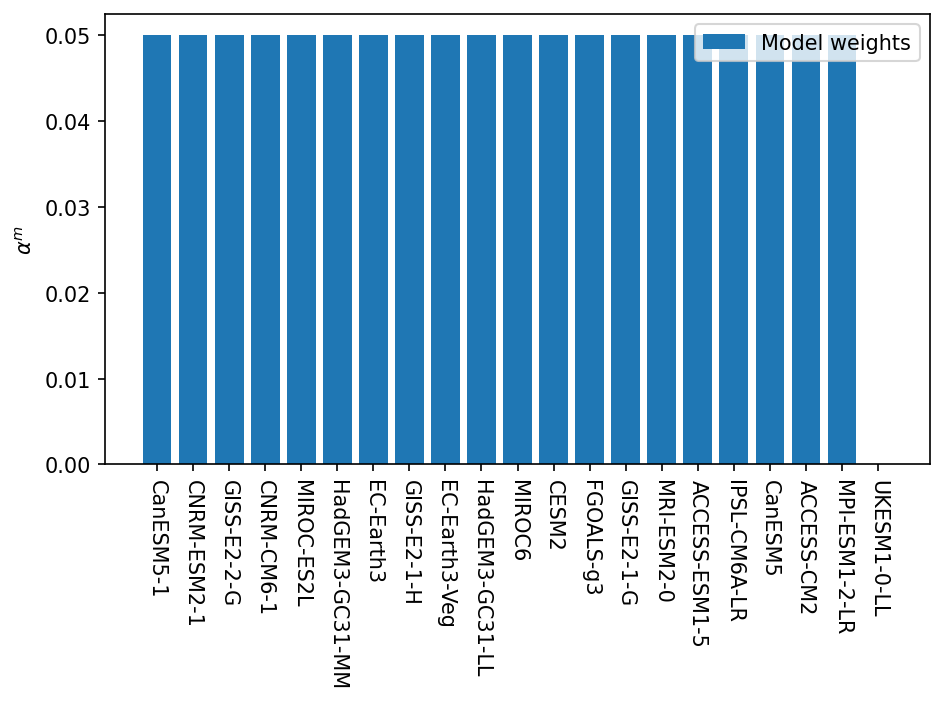

/tmp/ipykernel_12120/1818005261.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


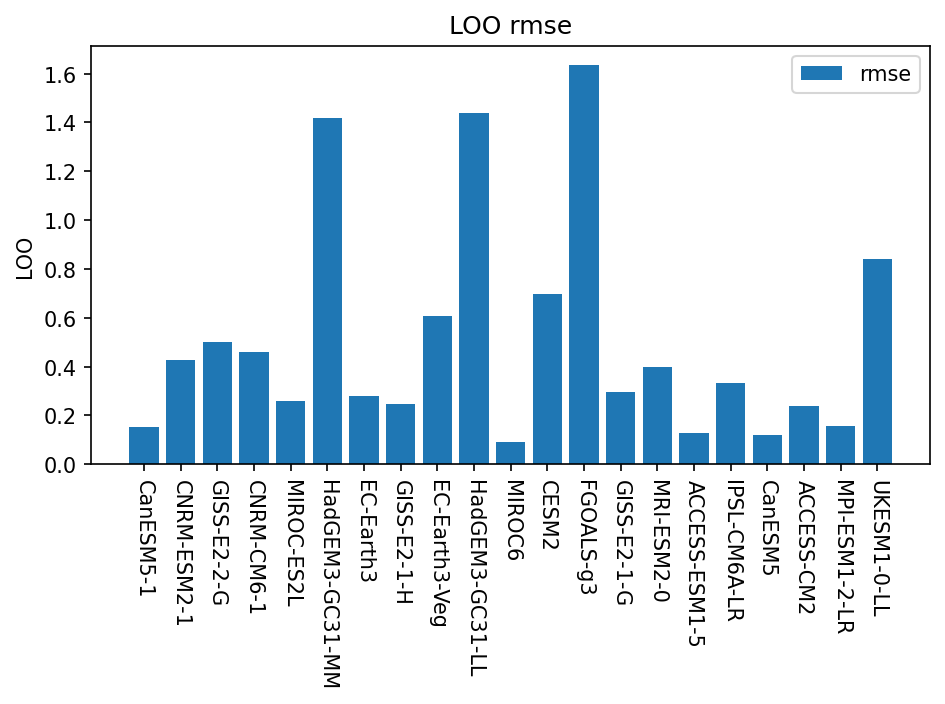

In [30]:
plt.close("all")

lambda_tmp = 100.0
mu_tmp = 1000.0
rank_tmp = 10

W_ridge, rmse_mean_ridge, training_loss_ridge, weights_ridge = leave_one_out_procedure(x,y,vars,\
                                                            lon_size,lat_size,notnan_idx,\
                                                            lr=0.000001, nb_gradient_iterations=20,time_period=33,\
                                                            rank=rank_tmp,lambda_=lambda_tmp,method='ridge',mu_=mu_tmp,verbose=True)

Loss function:  2306692.376091139
RMSE (mean) on model  CanESM5-1  :  0.13998335662585826
Loss function:  2301905.288578962
RMSE (mean) on model  CNRM-ESM2-1  :  0.4671742567596658
Loss function:  2283192.775538384
RMSE (mean) on model  GISS-E2-2-G  :  0.5649366710655052
Loss function:  2278992.2483068425
RMSE (mean) on model  CNRM-CM6-1  :  0.4958884209584451
Loss function:  2296472.2199172187
RMSE (mean) on model  MIROC-ES2L  :  0.2621022310689359
Loss function:  2191381.732127006
RMSE (mean) on model  HadGEM3-GC31-MM  :  1.4893048964428146
Loss function:  2304671.636790405
RMSE (mean) on model  EC-Earth3  :  0.2898479071670914
Loss function:  2310469.9700980526
RMSE (mean) on model  GISS-E2-1-H  :  0.2493329247534909
Loss function:  2266802.2030534106
RMSE (mean) on model  EC-Earth3-Veg  :  0.6812055032085332
Loss function:  2185984.883554661
RMSE (mean) on model  HadGEM3-GC31-LL  :  1.5396569050268603
Loss function:  2264369.2403532164
RMSE (mean) on model  MIROC6  :  0.07394319643

/tmp/ipykernel_12120/1818005261.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


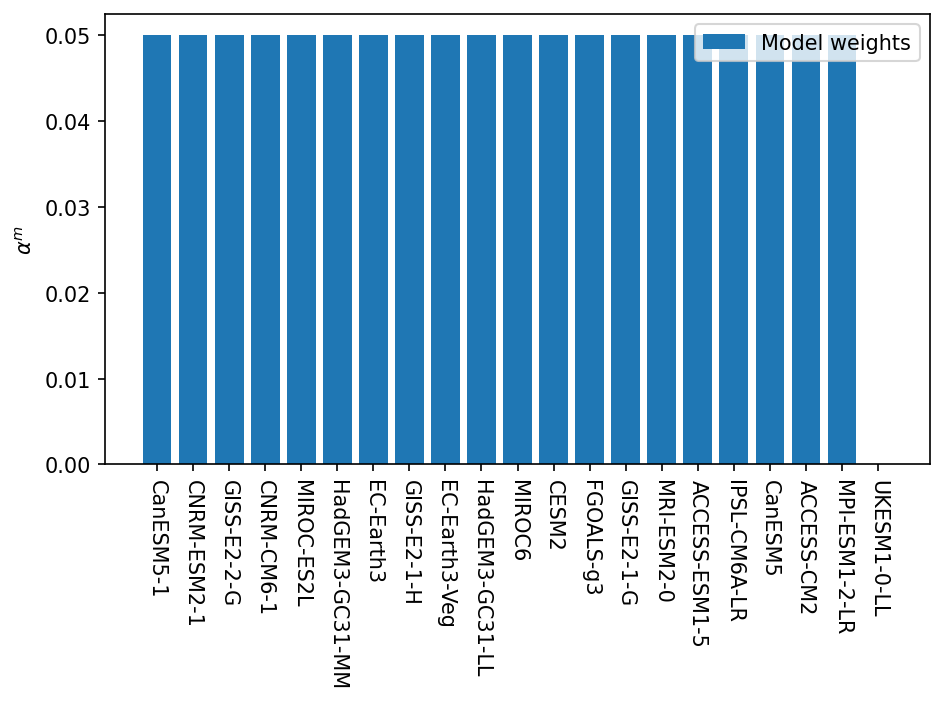

/tmp/ipykernel_12120/1818005261.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


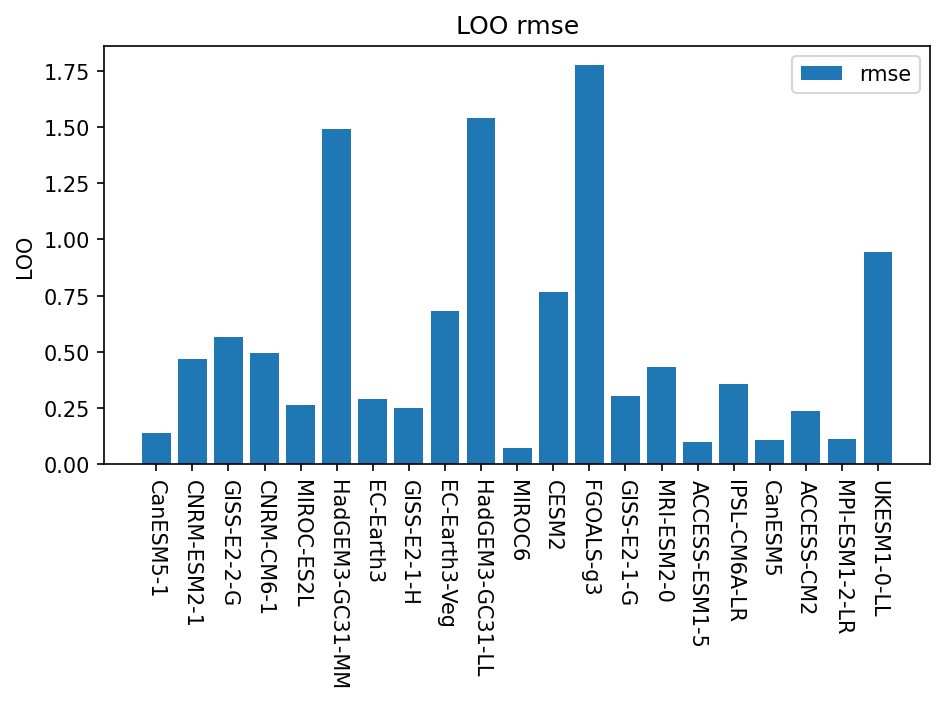

In [31]:
W_rrr, rmse_mean_rrr, training_loss_rrr, weights_rrr = leave_one_out_procedure(x,y,vars,\
                                                            lon_size,lat_size,notnan_idx,\
                                                            lr=0.000001, nb_gradient_iterations=20,time_period=33,\
                                                            rank=rank_tmp,lambda_=lambda_tmp,method='rrr',mu_=mu_tmp,verbose=True)

Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.05859375
Iteration  12 : Loss function :  31000.50390625
Iteration  13 : Loss function :  30018.359375
Iteration  14 : Loss function :  29091.359375
Iteration  15 : Loss function :  28348.720703125
Iteration  16 : Loss function :  27690.029296875
Iteration  17 : Loss function :  27090.14453125
Iteration  18 : Loss function :  26539.40625
Iteration  19 : Loss function :  26034.19140625
Iteration  20 : Loss function :  25574.970703125
Iteration  21 : Loss 

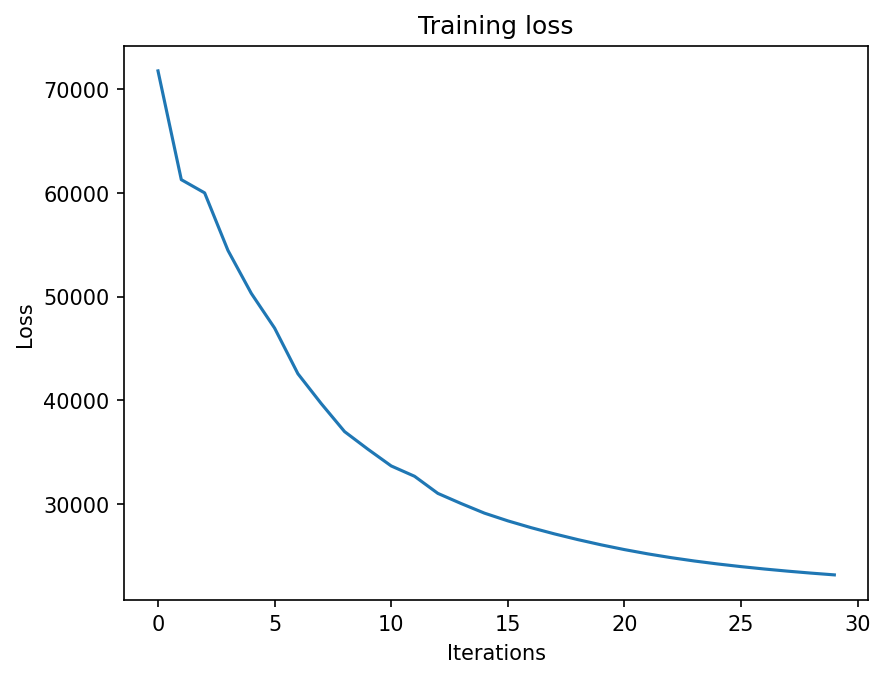

/tmp/ipykernel_12120/3923813946.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


RMSE (mean) on model  CanESM5-1  :  0.20491269819441155
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.056640625
Iteration  12 : Loss function :  31000.482421875
Iteration  13 : Loss function :  30018.30078125
Iteration  14 : Loss function :  29091.16015625
Iteration  15 : Loss function :  28348.28515625
Iteration  16 : Loss function :  27689.15234375
Iteration  17 : Loss function :  27088.505859375
Iteration  18 : Loss function :  26536.5234375
Iteration  19 : Loss function :  26029.37890625
Iterati

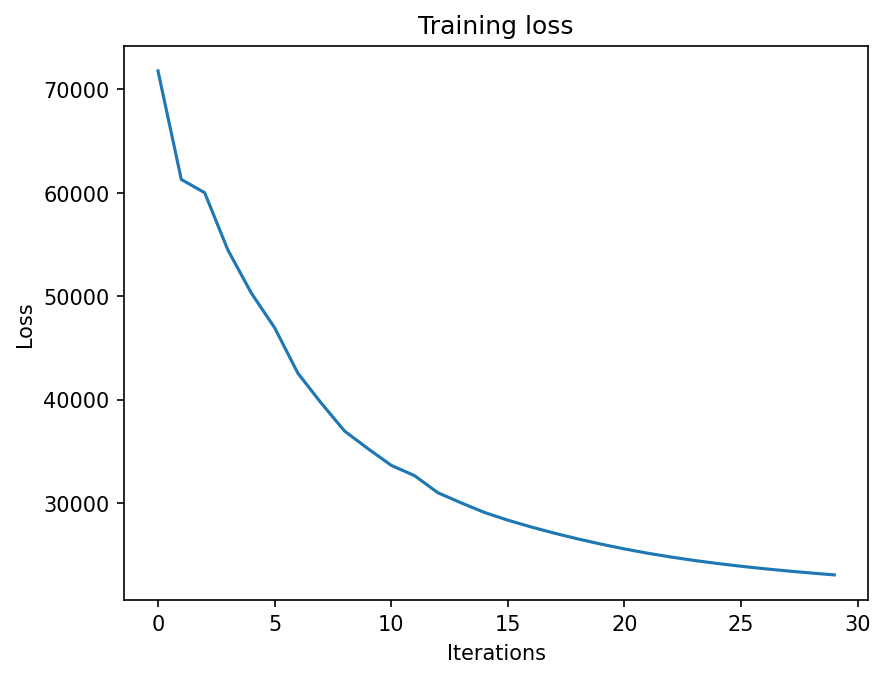

RMSE (mean) on model  CNRM-ESM2-1  :  0.4181329696877388
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.0546875
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.0703125
Iteration  11 : Loss function :  32652.048828125
Iteration  12 : Loss function :  31000.330078125
Iteration  13 : Loss function :  30017.939453125
Iteration  14 : Loss function :  29089.96484375
Iteration  15 : Loss function :  28345.7109375
Iteration  16 : Loss function :  27684.029296875
Iteration  17 : Loss function :  27079.03125
Iteration  18 : Loss function :  26520.064453125
Iteration  19 : Loss function :  26002.5234375
Iteratio

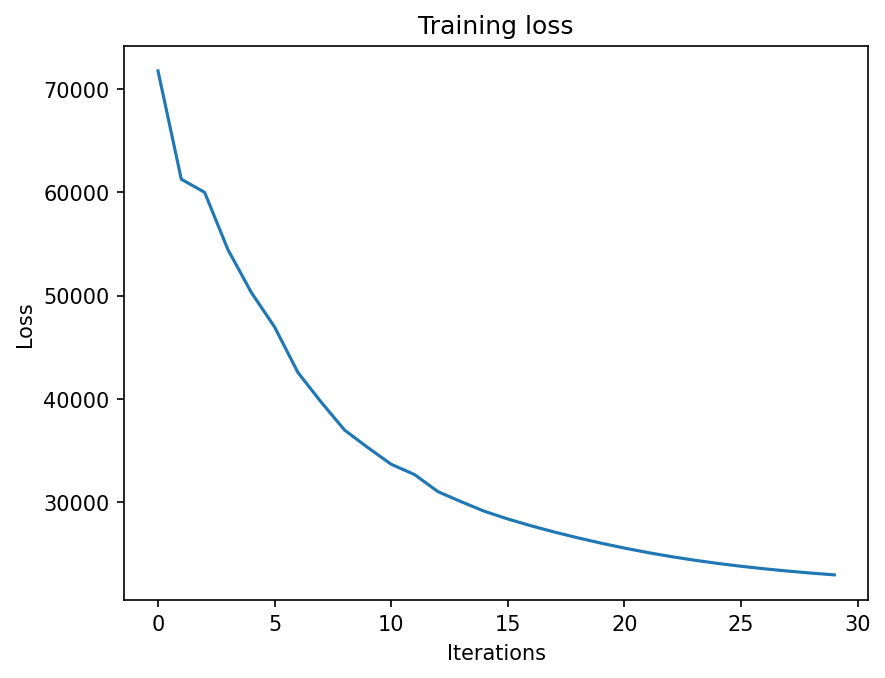

RMSE (mean) on model  GISS-E2-2-G  :  0.46664198078088936
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.056640625
Iteration  12 : Loss function :  31000.484375
Iteration  13 : Loss function :  30018.314453125
Iteration  14 : Loss function :  29091.203125
Iteration  15 : Loss function :  28348.373046875
Iteration  16 : Loss function :  27689.31640625
Iteration  17 : Loss function :  27088.798828125
Iteration  18 : Loss function :  26537.005859375
Iteration  19 : Loss function :  26030.125
Iteration  

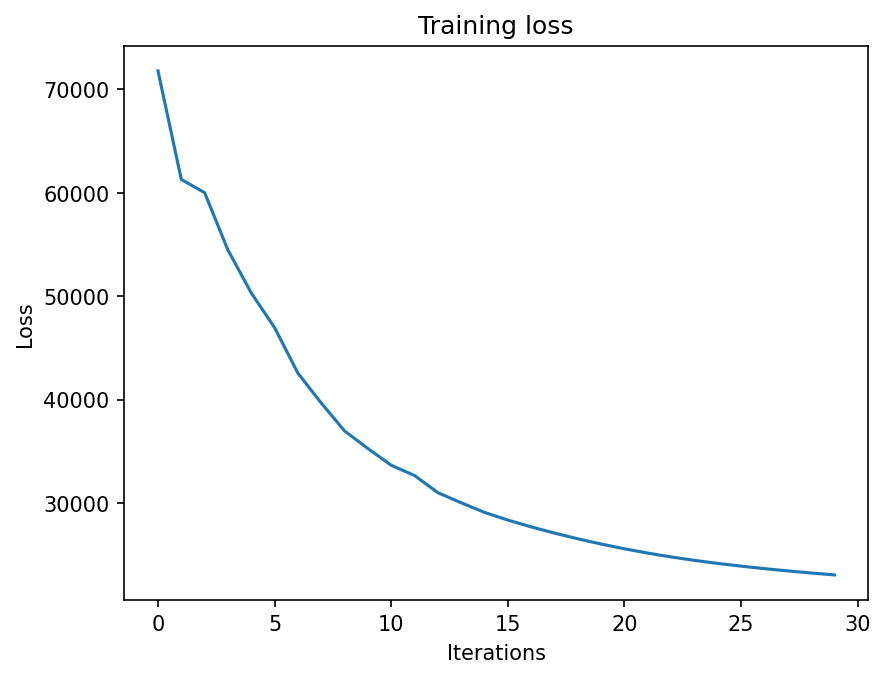

RMSE (mean) on model  CNRM-CM6-1  :  0.4204086844662894
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.05859375
Iteration  12 : Loss function :  31000.50390625
Iteration  13 : Loss function :  30018.359375
Iteration  14 : Loss function :  29091.359375
Iteration  15 : Loss function :  28348.720703125
Iteration  16 : Loss function :  27690.029296875
Iteration  17 : Loss function :  27090.14453125
Iteration  18 : Loss function :  26539.40625
Iteration  19 : Loss function :  26034.1875
Iteration  20 : Lo

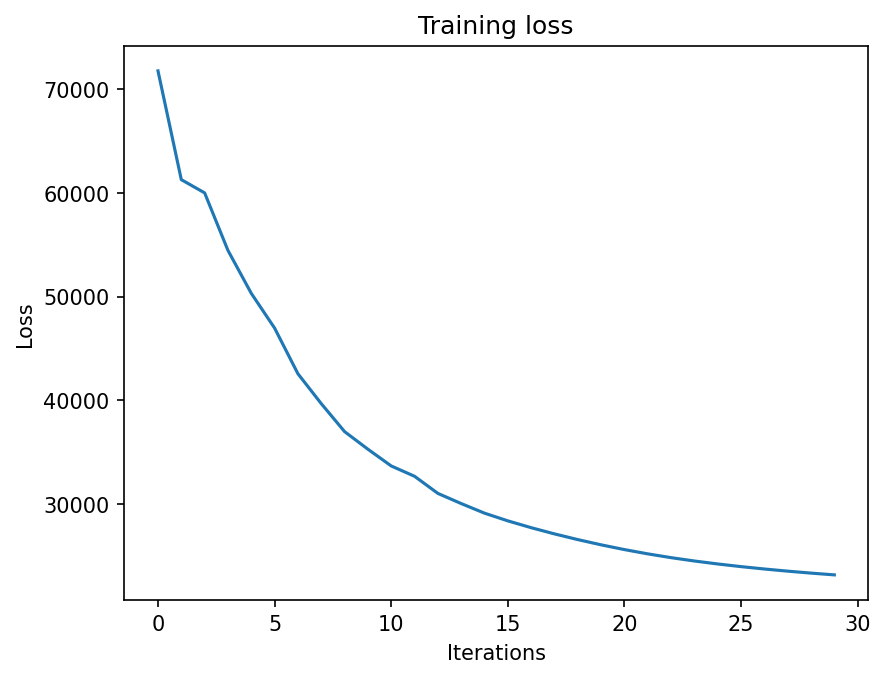

RMSE (mean) on model  MIROC-ES2L  :  0.26688398967067195
Iteration  0 : Loss function :  71815.1328125
Iteration  1 : Loss function :  56662.83203125
Iteration  2 : Loss function :  54510.16015625
Iteration  3 : Loss function :  51718.9375
Iteration  4 : Loss function :  43840.57421875
Iteration  5 : Loss function :  41506.421875
Iteration  6 : Loss function :  37379.4296875
Iteration  7 : Loss function :  35881.6953125
Iteration  8 : Loss function :  33513.09375
Iteration  9 : Loss function :  32358.203125
Iteration  10 : Loss function :  30261.388671875
Iteration  11 : Loss function :  29081.701171875
Iteration  12 : Loss function :  28188.55859375
Iteration  13 : Loss function :  27429.6640625
Iteration  14 : Loss function :  26753.01953125
Iteration  15 : Loss function :  26127.904296875
Iteration  16 : Loss function :  25551.08203125
Iteration  17 : Loss function :  25026.392578125
Iteration  18 : Loss function :  24556.6484375
Iteration  19 : Loss function :  24140.34375
Iteratio

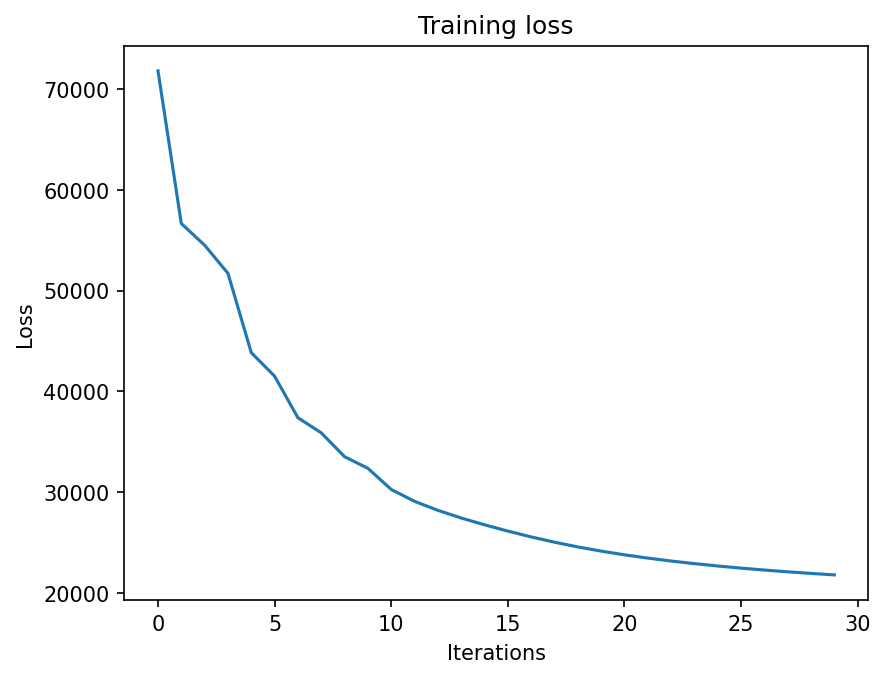

RMSE (mean) on model  HadGEM3-GC31-MM  :  1.1415167106008053
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.056640625
Iteration  12 : Loss function :  31000.50390625
Iteration  13 : Loss function :  30018.359375
Iteration  14 : Loss function :  29091.357421875
Iteration  15 : Loss function :  28348.716796875
Iteration  16 : Loss function :  27690.0234375
Iteration  17 : Loss function :  27090.13671875
Iteration  18 : Loss function :  26539.388671875
Iteration  19 : Loss function :  26034.1640625
Iter

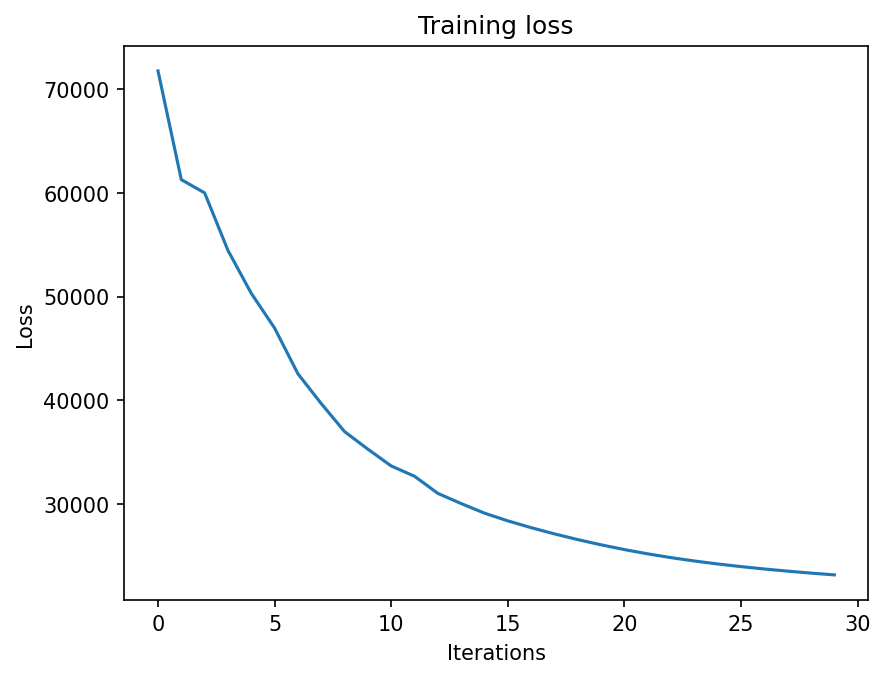

RMSE (mean) on model  EC-Earth3  :  0.2982602500619097
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.056640625
Iteration  12 : Loss function :  31000.50390625
Iteration  13 : Loss function :  30018.359375
Iteration  14 : Loss function :  29091.35546875
Iteration  15 : Loss function :  28348.7109375
Iteration  16 : Loss function :  27690.013671875
Iteration  17 : Loss function :  27090.11328125
Iteration  18 : Loss function :  26539.34375
Iteration  19 : Loss function :  26034.078125
Iteration  20 : 

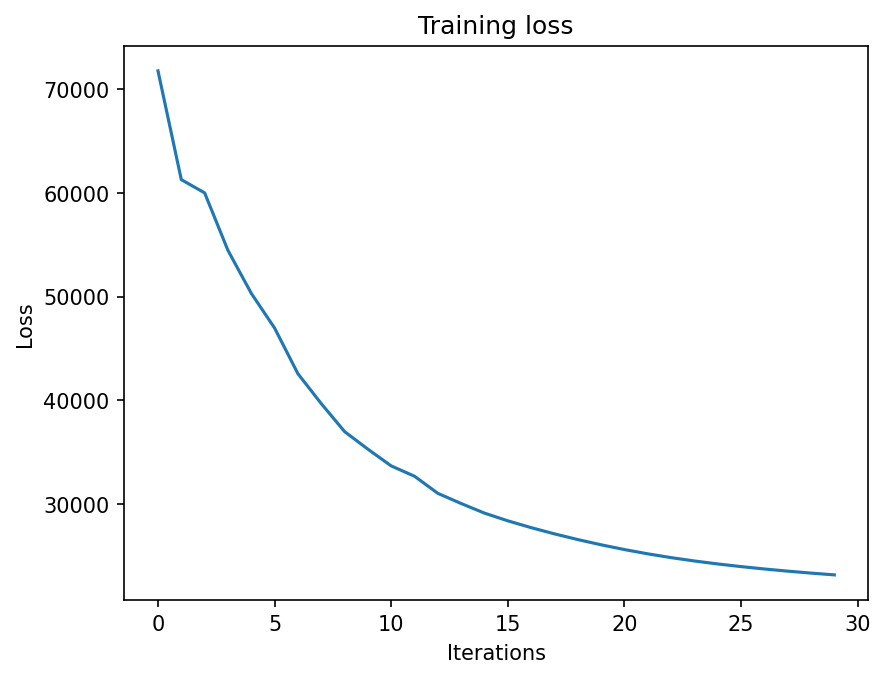

RMSE (mean) on model  GISS-E2-1-H  :  0.3415669670568009
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.734375
Iteration  8 : Loss function :  36963.96484375
Iteration  9 : Loss function :  35264.859375
Iteration  10 : Loss function :  33646.96484375
Iteration  11 : Loss function :  32646.533203125
Iteration  12 : Loss function :  30972.87109375
Iteration  13 : Loss function :  29950.240234375
Iteration  14 : Loss function :  28925.365234375
Iteration  15 : Loss function :  28080.470703125
Iteration  16 : Loss function :  27319.24609375
Iteration  17 : Loss function :  26632.701171875
Iteration  18 : Loss function :  26017.412109375
Iteration  19 : Loss function :  25469.296875
Iter

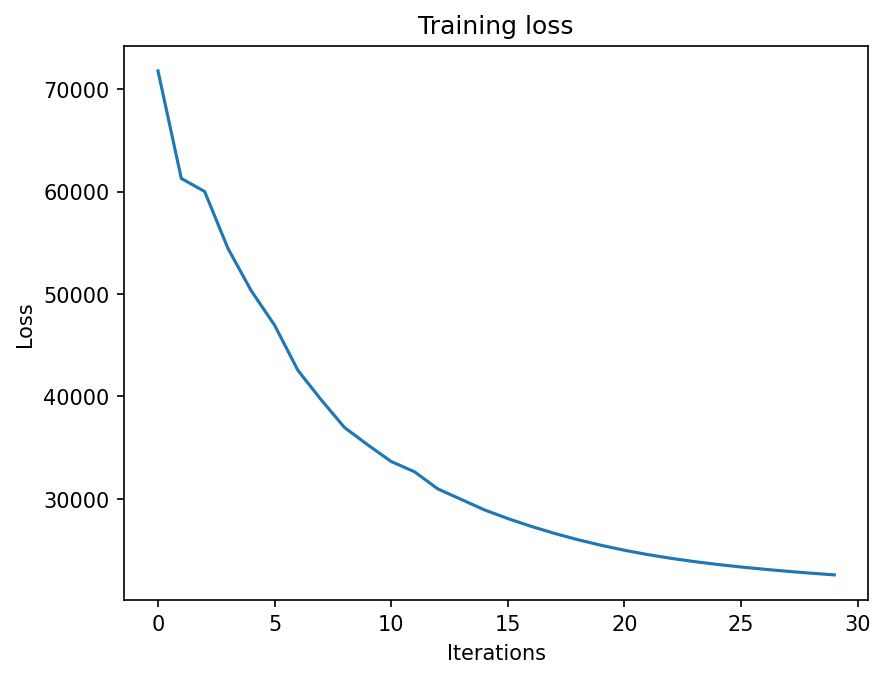

RMSE (mean) on model  EC-Earth3-Veg  :  0.5723721675763911
Iteration  0 : Loss function :  65780.4765625
Iteration  1 : Loss function :  57695.5546875
Iteration  2 : Loss function :  56822.13671875
Iteration  3 : Loss function :  47803.8984375
Iteration  4 : Loss function :  46273.46875
Iteration  5 : Loss function :  40291.56640625
Iteration  6 : Loss function :  37569.81640625
Iteration  7 : Loss function :  35320.3203125
Iteration  8 : Loss function :  33468.90625
Iteration  9 : Loss function :  32057.1015625
Iteration  10 : Loss function :  30773.64453125
Iteration  11 : Loss function :  29391.333984375
Iteration  12 : Loss function :  28420.724609375
Iteration  13 : Loss function :  27605.369140625
Iteration  14 : Loss function :  26875.45703125
Iteration  15 : Loss function :  26214.115234375
Iteration  16 : Loss function :  25613.1875
Iteration  17 : Loss function :  25071.01953125
Iteration  18 : Loss function :  24587.44921875
Iteration  19 : Loss function :  24160.103515625
I

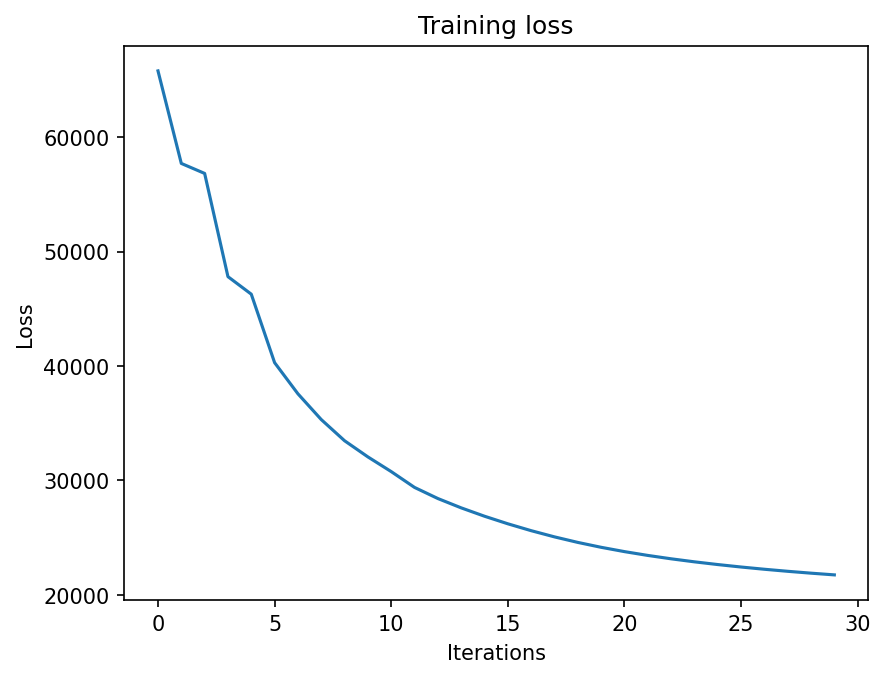

RMSE (mean) on model  HadGEM3-GC31-LL  :  1.1830580458986797
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.056640625
Iteration  12 : Loss function :  31000.50390625
Iteration  13 : Loss function :  30018.359375
Iteration  14 : Loss function :  29091.359375
Iteration  15 : Loss function :  28348.720703125
Iteration  16 : Loss function :  27690.029296875
Iteration  17 : Loss function :  27090.14453125
Iteration  18 : Loss function :  26539.40625
Iteration  19 : Loss function :  26034.19140625
Iteratio

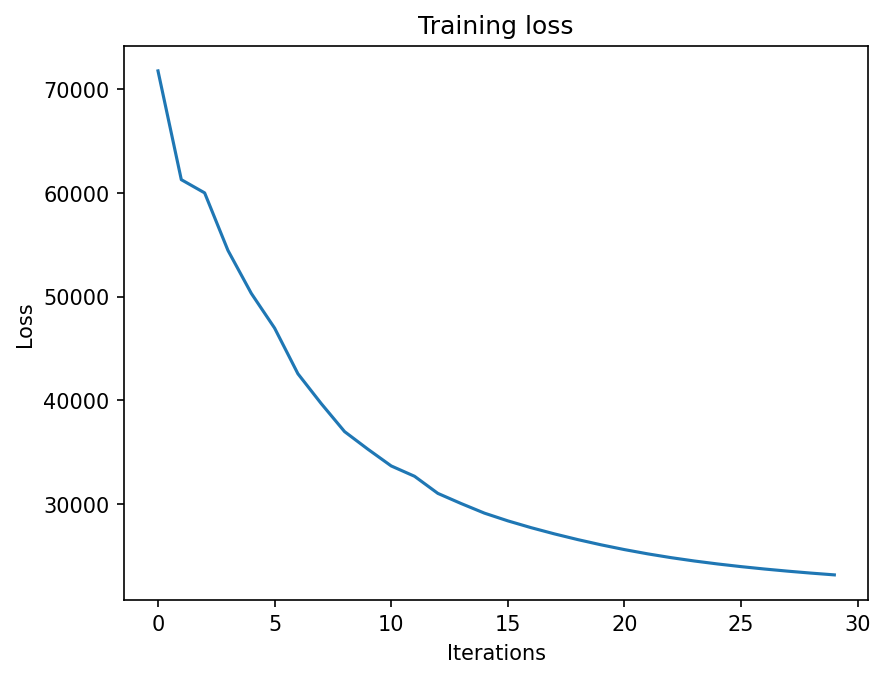

RMSE (mean) on model  MIROC6  :  0.14737133638542807
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.296875
Iteration  7 : Loss function :  39665.6796875
Iteration  8 : Loss function :  36963.23828125
Iteration  9 : Loss function :  35262.83984375
Iteration  10 : Loss function :  33637.48046875
Iteration  11 : Loss function :  32647.23828125
Iteration  12 : Loss function :  30867.958984375
Iteration  13 : Loss function :  29864.271484375
Iteration  14 : Loss function :  28697.890625
Iteration  15 : Loss function :  27852.361328125
Iteration  16 : Loss function :  27095.666015625
Iteration  17 : Loss function :  26402.0
Iteration  18 : Loss function :  25772.75
Iteration  19 : Loss function :  25215.126953125
Iteration  20 : Loss 

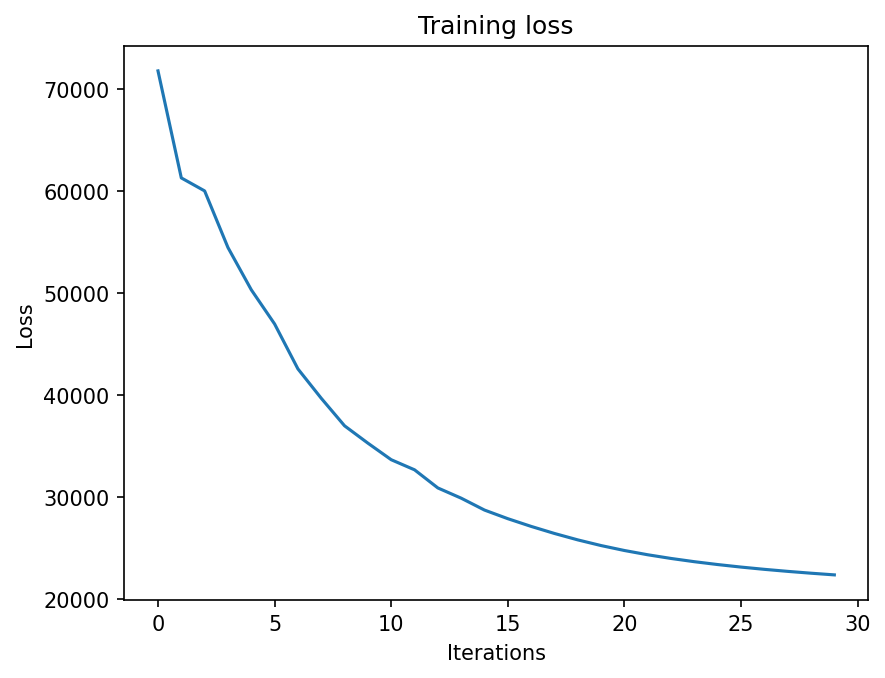

RMSE (mean) on model  CESM2  :  0.6187851203968493
Iteration  0 : Loss function :  61418.87109375
Iteration  1 : Loss function :  55026.76953125
Iteration  2 : Loss function :  52649.99609375
Iteration  3 : Loss function :  46323.98828125
Iteration  4 : Loss function :  44295.13671875
Iteration  5 : Loss function :  39152.37109375
Iteration  6 : Loss function :  36997.69921875
Iteration  7 : Loss function :  35099.66796875
Iteration  8 : Loss function :  34255.453125
Iteration  9 : Loss function :  31794.373046875
Iteration  10 : Loss function :  30670.962890625
Iteration  11 : Loss function :  29402.091796875
Iteration  12 : Loss function :  28390.869140625
Iteration  13 : Loss function :  27590.712890625
Iteration  14 : Loss function :  26842.484375
Iteration  15 : Loss function :  26188.51171875
Iteration  16 : Loss function :  25587.384765625
Iteration  17 : Loss function :  25043.18359375
Iteration  18 : Loss function :  24557.404296875
Iteration  19 : Loss function :  24128.07031

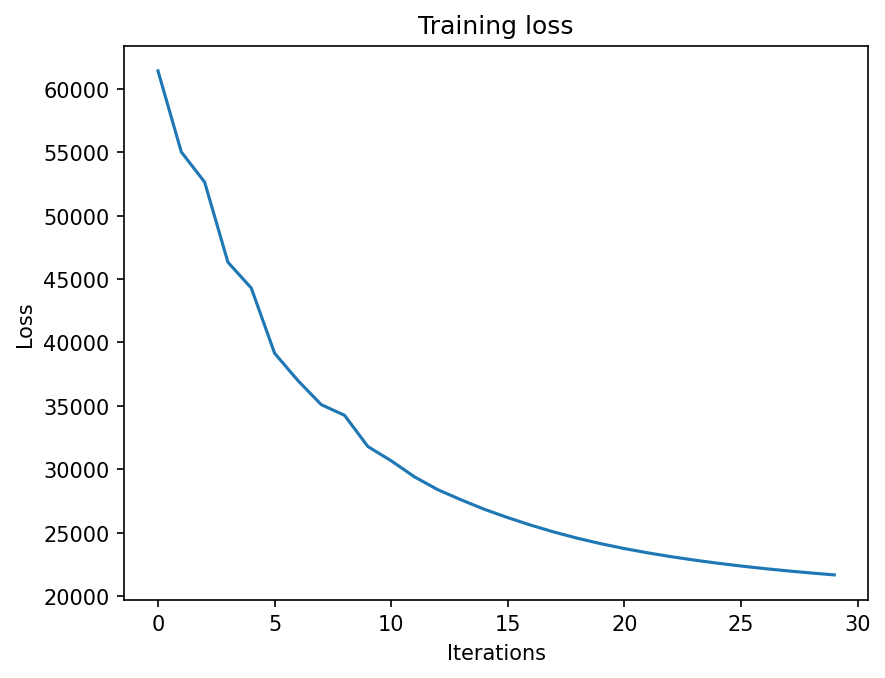

RMSE (mean) on model  FGOALS-g3  :  1.3288653428018795
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.056640625
Iteration  12 : Loss function :  31000.501953125
Iteration  13 : Loss function :  30018.357421875
Iteration  14 : Loss function :  29091.3515625
Iteration  15 : Loss function :  28348.697265625
Iteration  16 : Loss function :  27689.98046875
Iteration  17 : Loss function :  27090.046875
Iteration  18 : Loss function :  26539.21875
Iteration  19 : Loss function :  26033.849609375
Iteration  

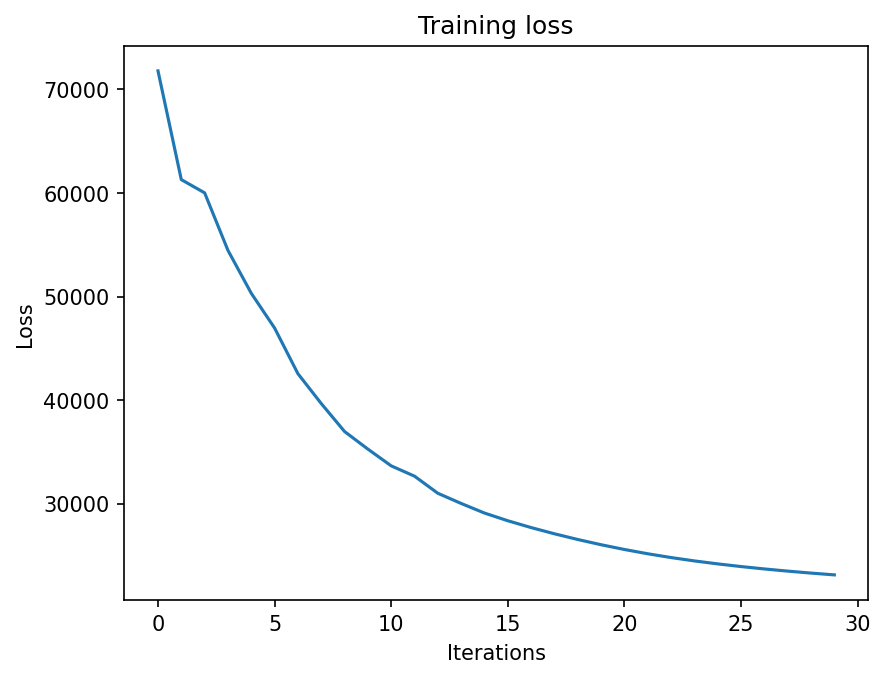

RMSE (mean) on model  GISS-E2-1-G  :  0.3673363710136894
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.056640625
Iteration  12 : Loss function :  31000.498046875
Iteration  13 : Loss function :  30018.345703125
Iteration  14 : Loss function :  29091.3125
Iteration  15 : Loss function :  28348.619140625
Iteration  16 : Loss function :  27689.830078125
Iteration  17 : Loss function :  27089.76953125
Iteration  18 : Loss function :  26538.732421875
Iteration  19 : Loss function :  26033.041015625
Itera

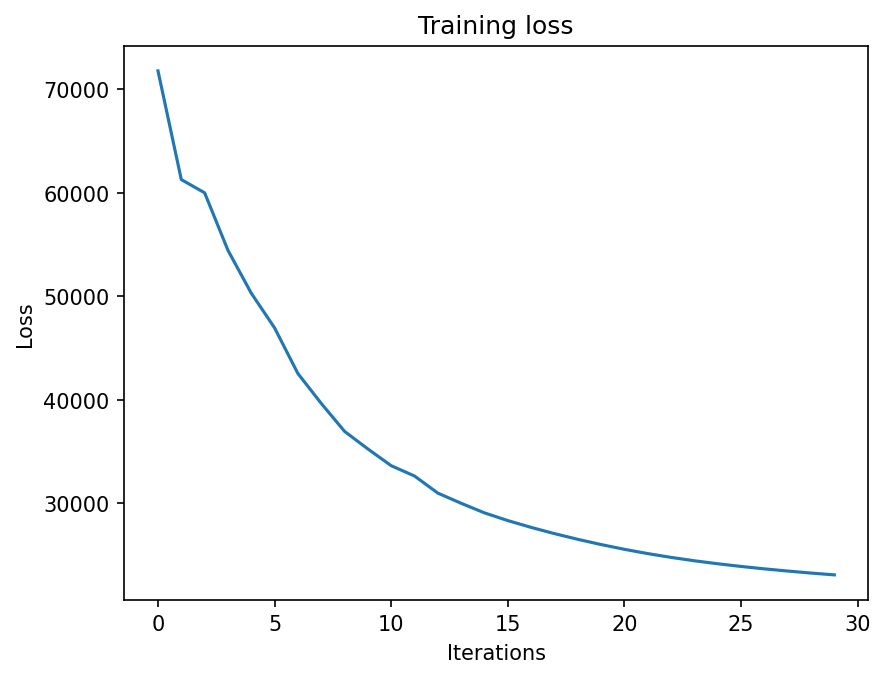

RMSE (mean) on model  MRI-ESM2-0  :  0.39195192466157774
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.05859375
Iteration  12 : Loss function :  31000.50390625
Iteration  13 : Loss function :  30018.359375
Iteration  14 : Loss function :  29091.359375
Iteration  15 : Loss function :  28348.720703125
Iteration  16 : Loss function :  27690.029296875
Iteration  17 : Loss function :  27090.14453125
Iteration  18 : Loss function :  26539.40625
Iteration  19 : Loss function :  26034.19140625
Iteration  20

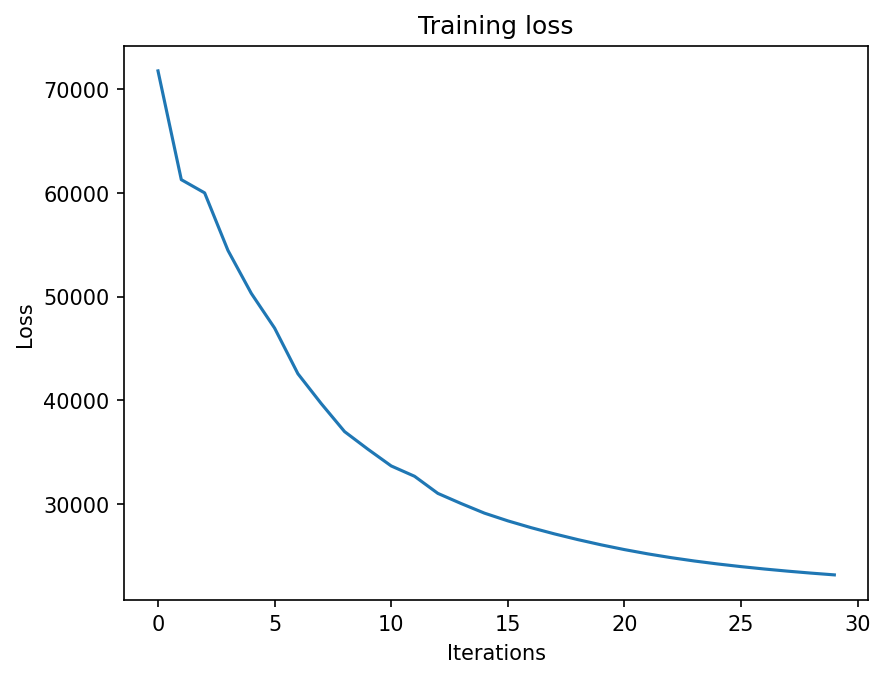

RMSE (mean) on model  ACCESS-ESM1-5  :  0.16006843844350463
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.05859375
Iteration  12 : Loss function :  31000.50390625
Iteration  13 : Loss function :  30018.359375
Iteration  14 : Loss function :  29091.35546875
Iteration  15 : Loss function :  28348.712890625
Iteration  16 : Loss function :  27690.015625
Iteration  17 : Loss function :  27090.11328125
Iteration  18 : Loss function :  26539.34765625
Iteration  19 : Loss function :  26034.0859375
Iteration

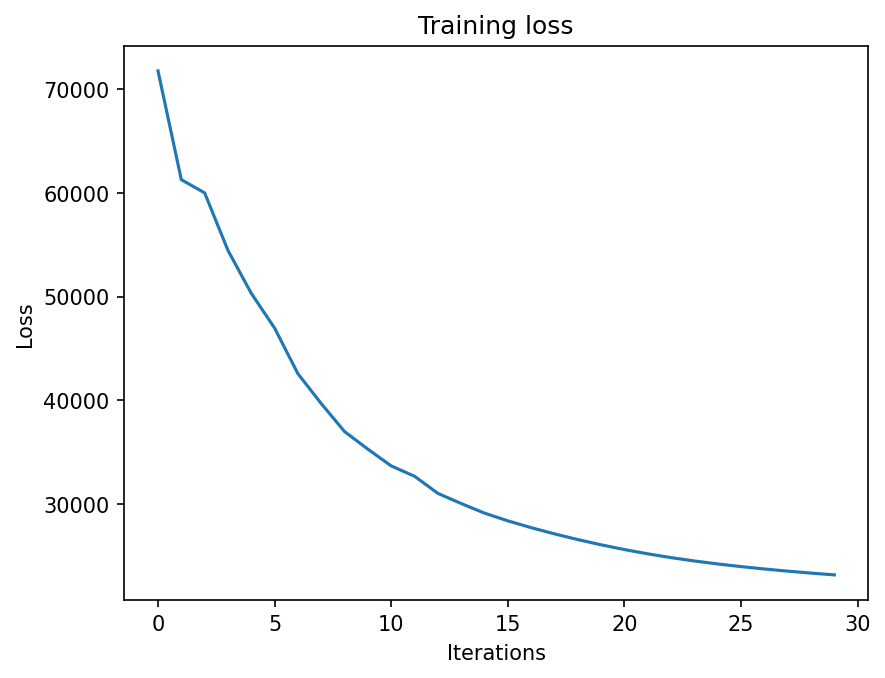

RMSE (mean) on model  IPSL-CM6A-LR  :  0.33775093371157044
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.05859375
Iteration  12 : Loss function :  31000.50390625
Iteration  13 : Loss function :  30018.359375
Iteration  14 : Loss function :  29091.359375
Iteration  15 : Loss function :  28348.720703125
Iteration  16 : Loss function :  27690.029296875
Iteration  17 : Loss function :  27090.14453125
Iteration  18 : Loss function :  26539.40625
Iteration  19 : Loss function :  26034.19140625
Iteration  

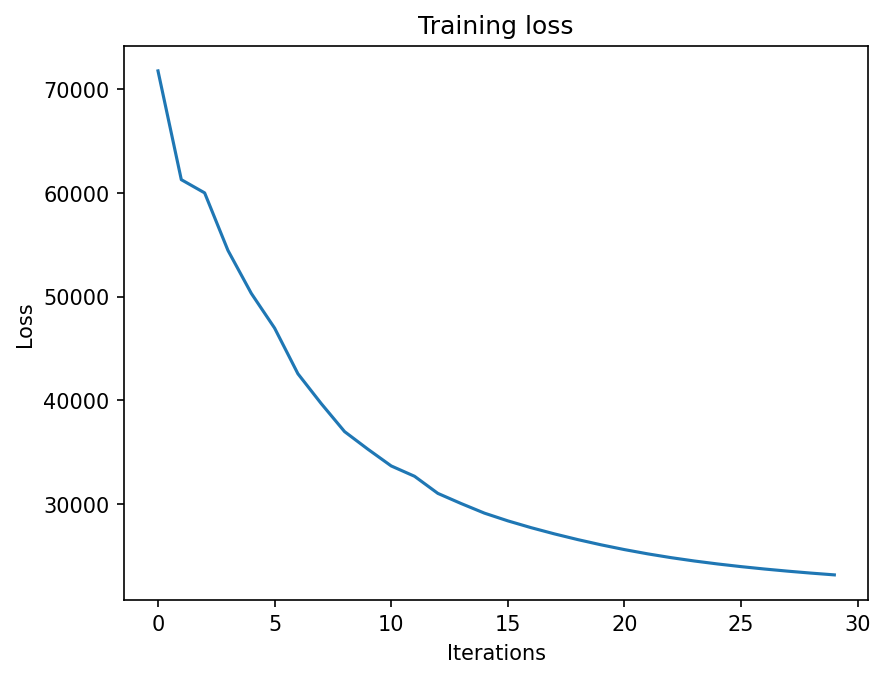

RMSE (mean) on model  CanESM5  :  0.18650208635362575
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.05859375
Iteration  12 : Loss function :  31000.50390625
Iteration  13 : Loss function :  30018.359375
Iteration  14 : Loss function :  29091.359375
Iteration  15 : Loss function :  28348.720703125
Iteration  16 : Loss function :  27690.02734375
Iteration  17 : Loss function :  27090.142578125
Iteration  18 : Loss function :  26539.40234375
Iteration  19 : Loss function :  26034.185546875
Iteration  2

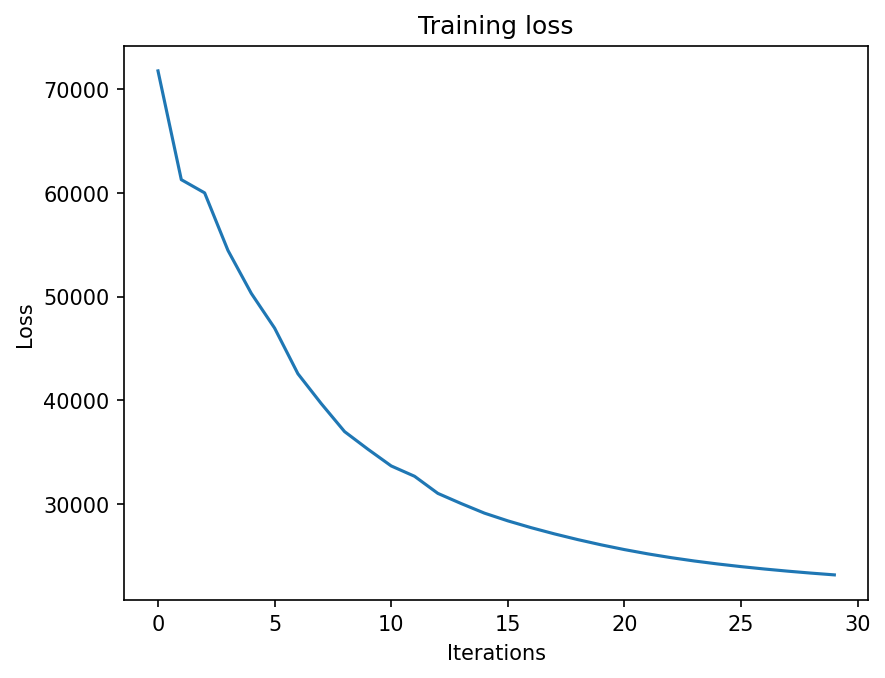

RMSE (mean) on model  ACCESS-CM2  :  0.28266136239867257
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.37109375
Iteration  6 : Loss function :  42547.30078125
Iteration  7 : Loss function :  39665.73828125
Iteration  8 : Loss function :  36964.05859375
Iteration  9 : Loss function :  35265.328125
Iteration  10 : Loss function :  33649.078125
Iteration  11 : Loss function :  32652.05859375
Iteration  12 : Loss function :  31000.50390625
Iteration  13 : Loss function :  30018.359375
Iteration  14 : Loss function :  29091.359375
Iteration  15 : Loss function :  28348.720703125
Iteration  16 : Loss function :  27690.029296875
Iteration  17 : Loss function :  27090.14453125
Iteration  18 : Loss function :  26539.40625
Iteration  19 : Loss function :  26034.19140625
Iteration  20

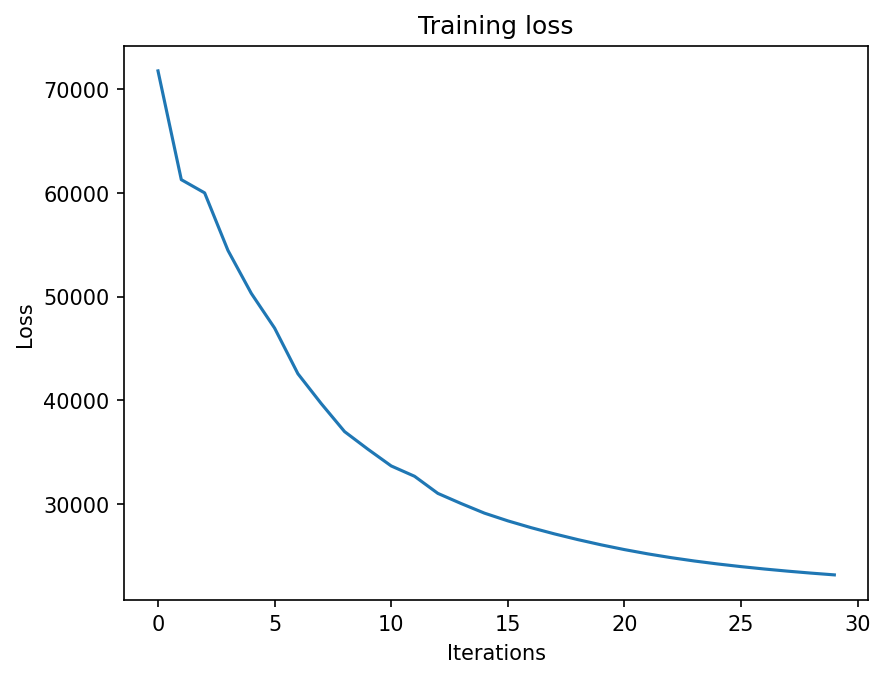

RMSE (mean) on model  MPI-ESM1-2-LR  :  0.15357857216007192
Iteration  0 : Loss function :  71783.09375
Iteration  1 : Loss function :  61283.3125
Iteration  2 : Loss function :  60007.21875
Iteration  3 : Loss function :  54454.0703125
Iteration  4 : Loss function :  50309.55078125
Iteration  5 : Loss function :  46955.31640625
Iteration  6 : Loss function :  42544.40625
Iteration  7 : Loss function :  39639.82421875
Iteration  8 : Loss function :  36666.56640625
Iteration  9 : Loss function :  34517.35546875
Iteration  10 : Loss function :  32434.29296875
Iteration  11 : Loss function :  30812.201171875
Iteration  12 : Loss function :  29580.546875
Iteration  13 : Loss function :  28594.3046875
Iteration  14 : Loss function :  27764.392578125
Iteration  15 : Loss function :  27031.3515625
Iteration  16 : Loss function :  26365.609375
Iteration  17 : Loss function :  25759.537109375
Iteration  18 : Loss function :  25215.595703125
Iteration  19 : Loss function :  24735.830078125
Itera

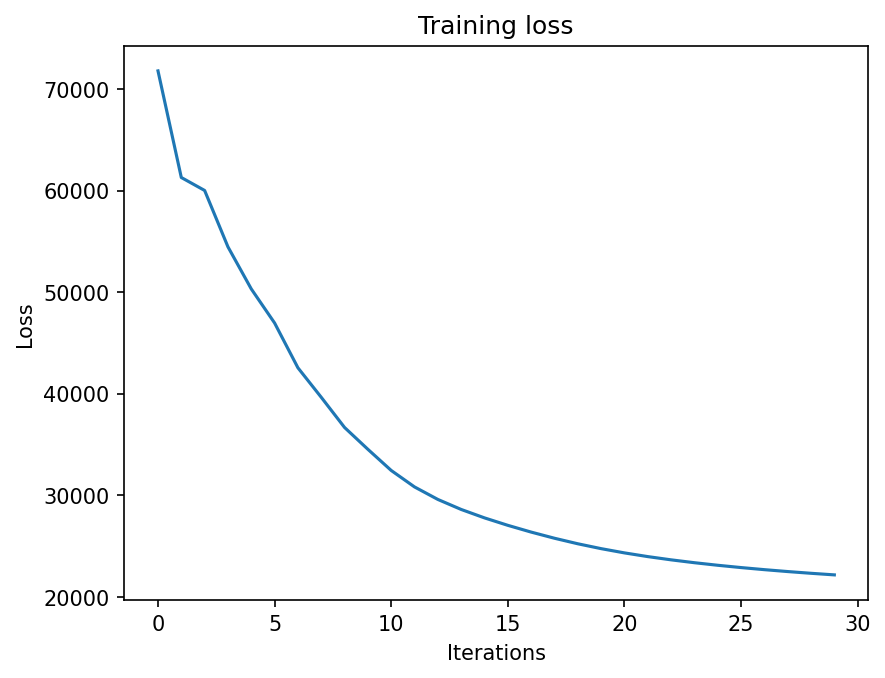

RMSE (mean) on model  UKESM1-0-LL  :  0.7394871701349097
Check that sum of weights ==1 :  tensor(1.0000)


/tmp/ipykernel_12120/1818005261.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


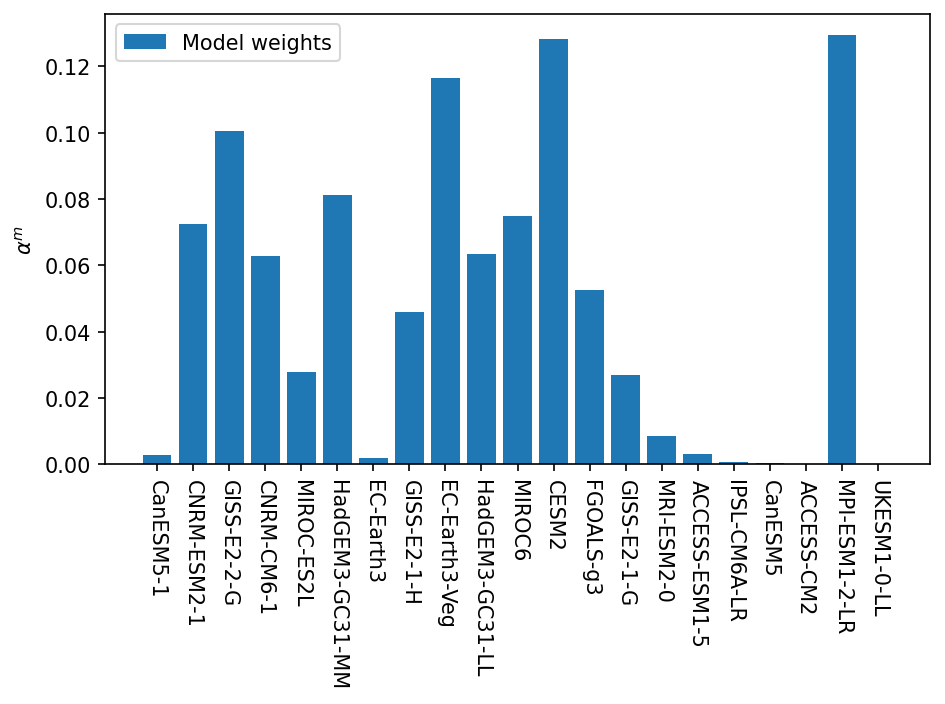

/tmp/ipykernel_12120/1818005261.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


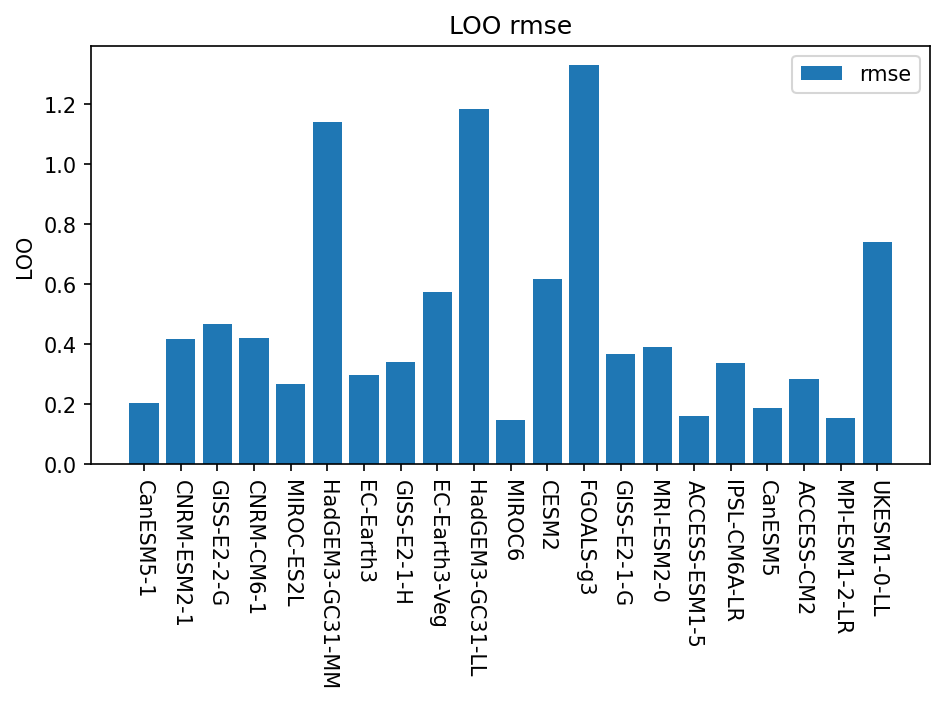

In [32]:
W_robust, rmse_mean_robust, training_loss_robust, weights_robust = leave_one_out_procedure(x,y,vars,\
                                                                    lon_size,lat_size,notnan_idx,\
                                                                    lr=0.0000001,nb_gradient_iterations=30, time_period=33,\
                                                                    rank=None,lambda_=lambda_tmp,method='robust',mu_=mu_tmp,verbose=True)


Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration  20 : Loss function :  44174.98046875
Iteration  21 : Los

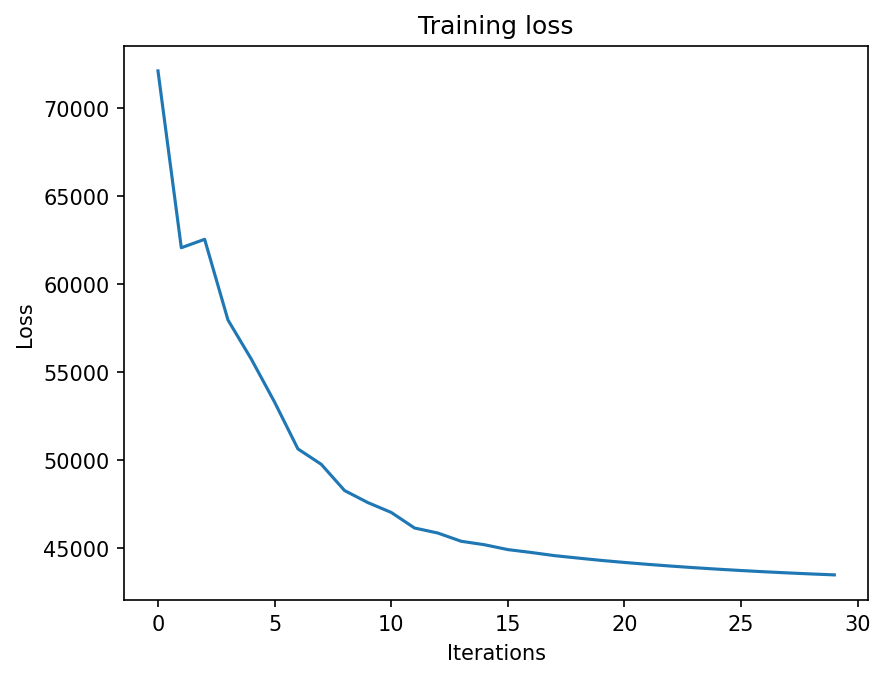

/tmp/ipykernel_12120/3923813946.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


RMSE (mean) on model  CanESM5-1  :  0.17368313011449696
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration  

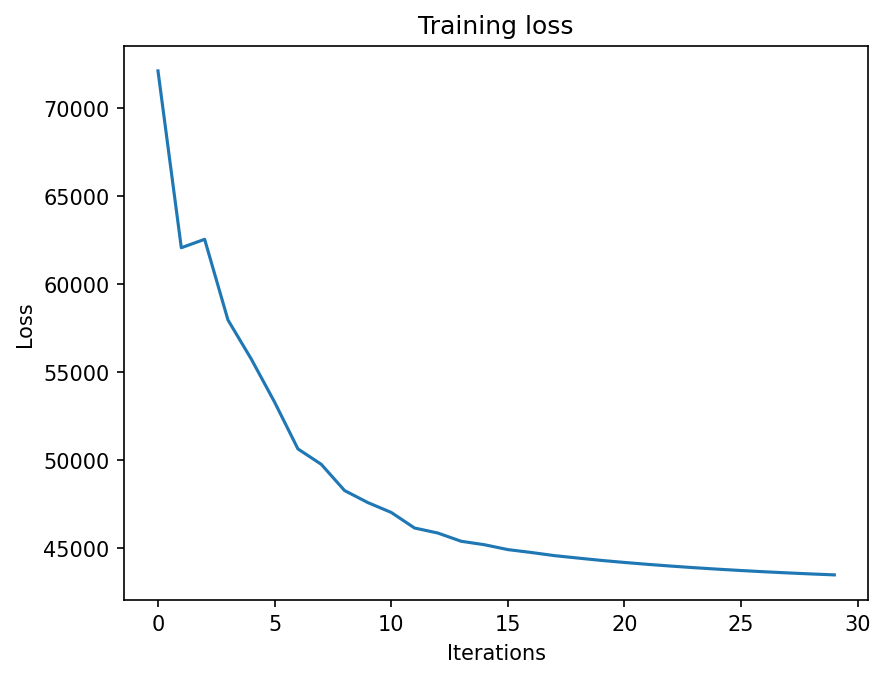

RMSE (mean) on model  CNRM-ESM2-1  :  0.493138254175734
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration  

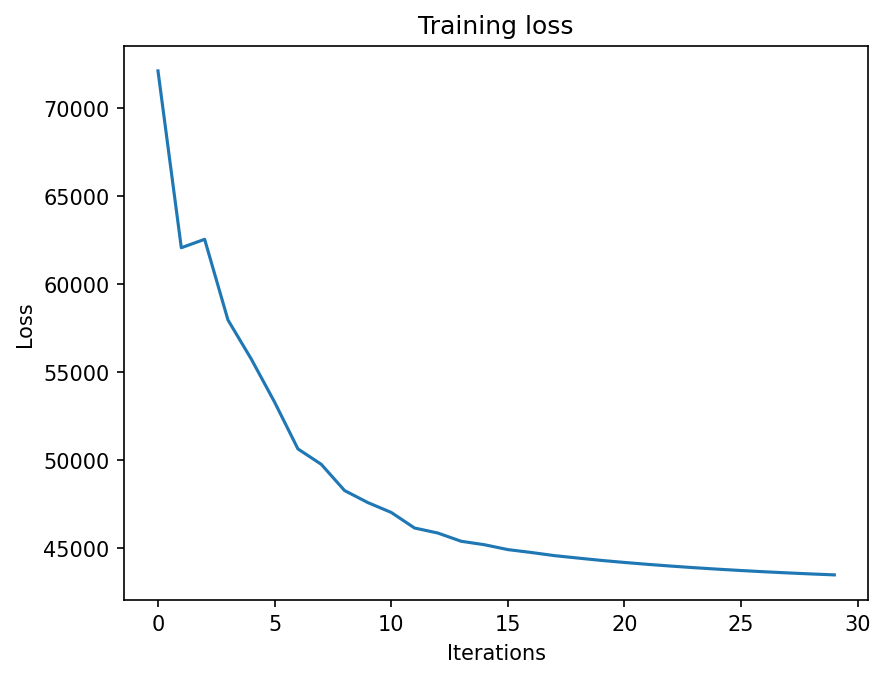

RMSE (mean) on model  GISS-E2-2-G  :  0.5506064648593341
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration 

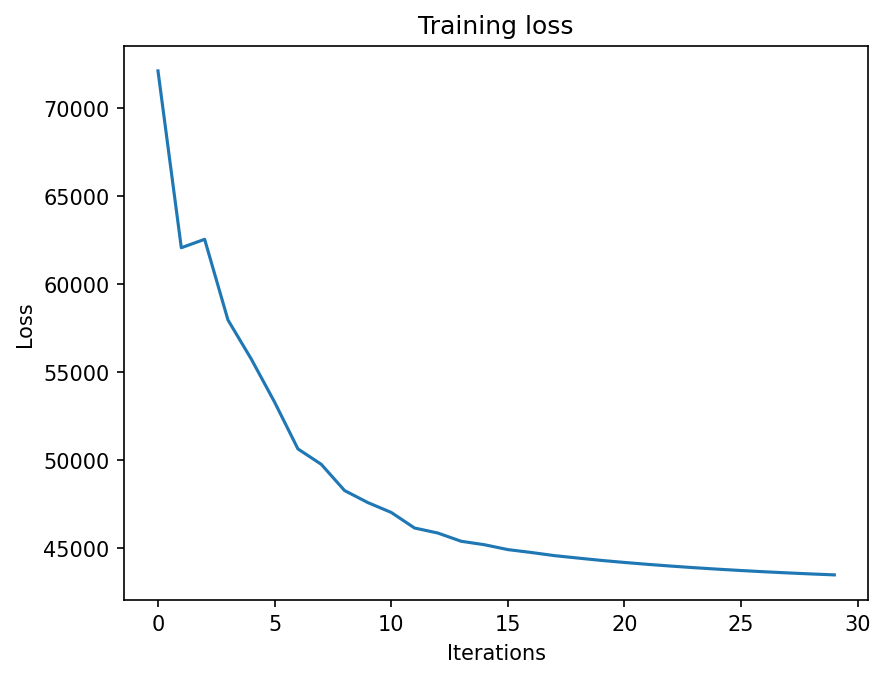

RMSE (mean) on model  CNRM-CM6-1  :  0.4917662512040538
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration  

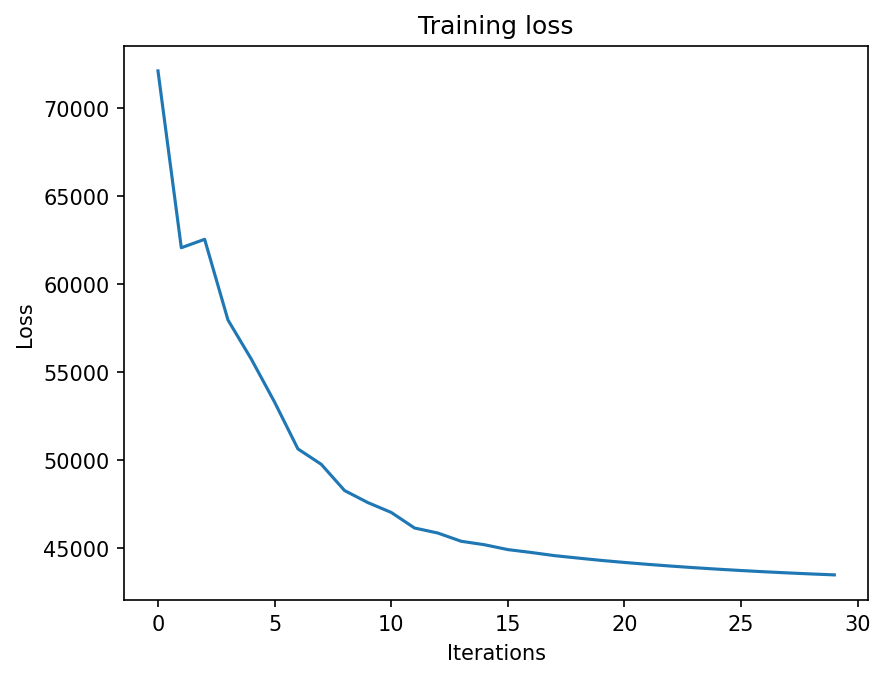

RMSE (mean) on model  MIROC-ES2L  :  0.2797673783209515
Iteration  0 : Loss function :  72168.8984375
Iteration  1 : Loss function :  59112.3125
Iteration  2 : Loss function :  57486.59765625
Iteration  3 : Loss function :  56314.2734375
Iteration  4 : Loss function :  49979.06640625
Iteration  5 : Loss function :  48841.87890625
Iteration  6 : Loss function :  45805.296875
Iteration  7 : Loss function :  44312.8359375
Iteration  8 : Loss function :  43175.62109375
Iteration  9 : Loss function :  42341.58984375
Iteration  10 : Loss function :  41737.18359375
Iteration  11 : Loss function :  41294.54296875
Iteration  12 : Loss function :  40964.32421875
Iteration  13 : Loss function :  40708.27734375
Iteration  14 : Loss function :  40501.37890625
Iteration  15 : Loss function :  40327.91015625
Iteration  16 : Loss function :  40178.0078125
Iteration  17 : Loss function :  40045.37109375
Iteration  18 : Loss function :  39925.9453125
Iteration  19 : Loss function :  39817.078125
Iterati

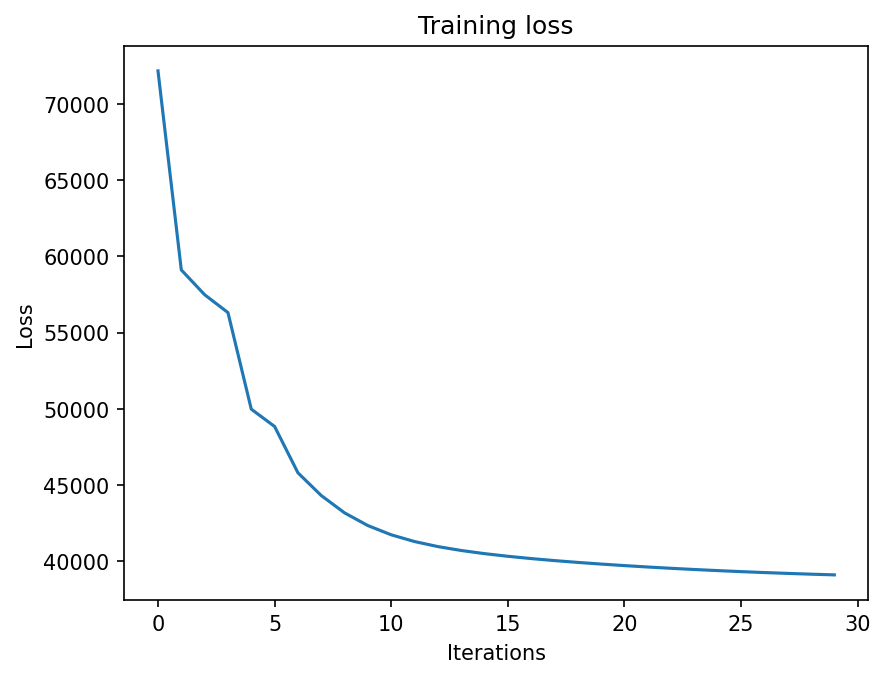

RMSE (mean) on model  HadGEM3-GC31-MM  :  1.375066435214229
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iterati

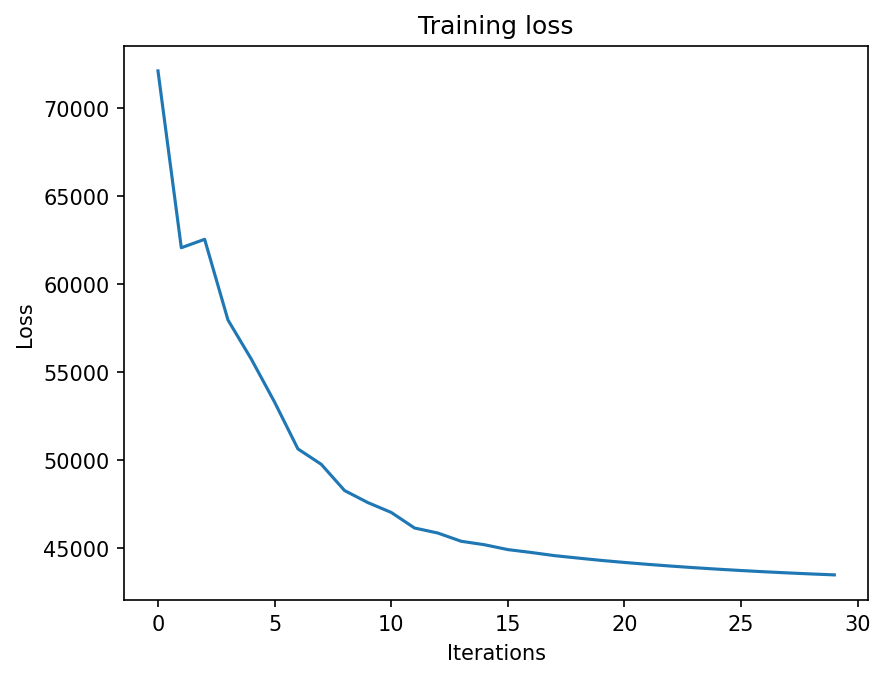

RMSE (mean) on model  EC-Earth3  :  0.3320993465210725
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration  2

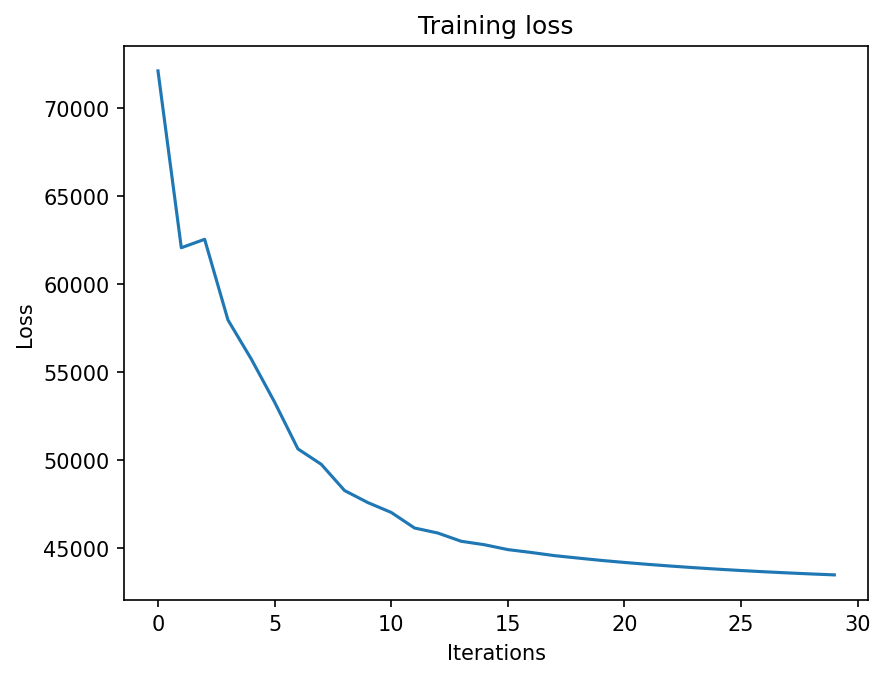

RMSE (mean) on model  GISS-E2-1-H  :  0.330000104539066
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.984375
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.7421875
Iteration  20 

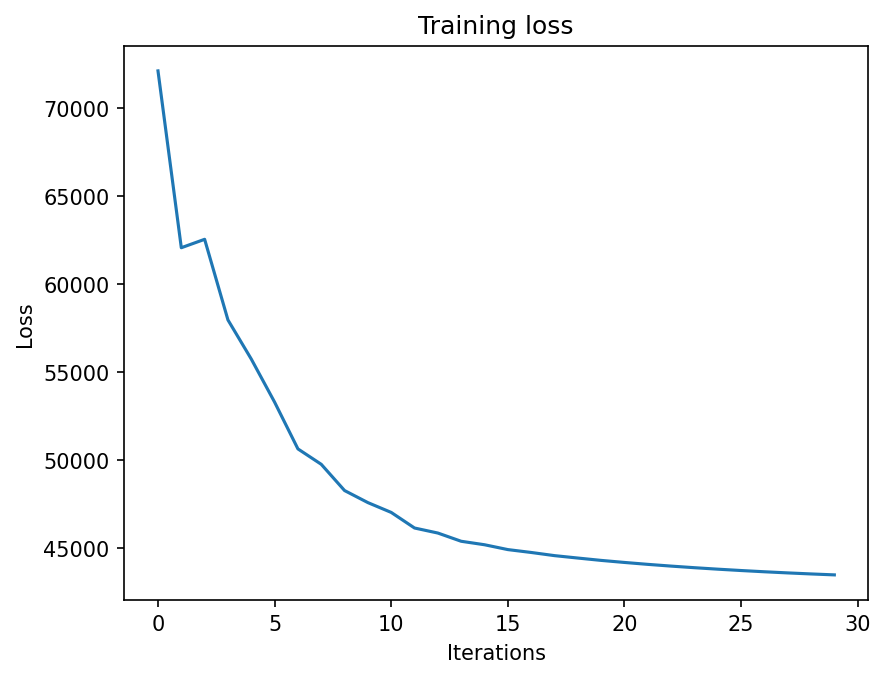

RMSE (mean) on model  EC-Earth3-Veg  :  0.7018081778721545
Iteration  0 : Loss function :  66996.7265625
Iteration  1 : Loss function :  59603.0390625
Iteration  2 : Loss function :  59957.140625
Iteration  3 : Loss function :  52500.8984375
Iteration  4 : Loss function :  52224.48046875
Iteration  5 : Loss function :  47701.34375
Iteration  6 : Loss function :  46342.9453125
Iteration  7 : Loss function :  44374.25390625
Iteration  8 : Loss function :  43166.8203125
Iteration  9 : Loss function :  42263.6171875
Iteration  10 : Loss function :  41611.3125
Iteration  11 : Loss function :  41133.9921875
Iteration  12 : Loss function :  40776.3984375
Iteration  13 : Loss function :  40500.671875
Iteration  14 : Loss function :  40280.15234375
Iteration  15 : Loss function :  40097.15234375
Iteration  16 : Loss function :  39939.16796875
Iteration  17 : Loss function :  39798.72265625
Iteration  18 : Loss function :  39670.84375
Iteration  19 : Loss function :  39553.01171875
Iteration  20

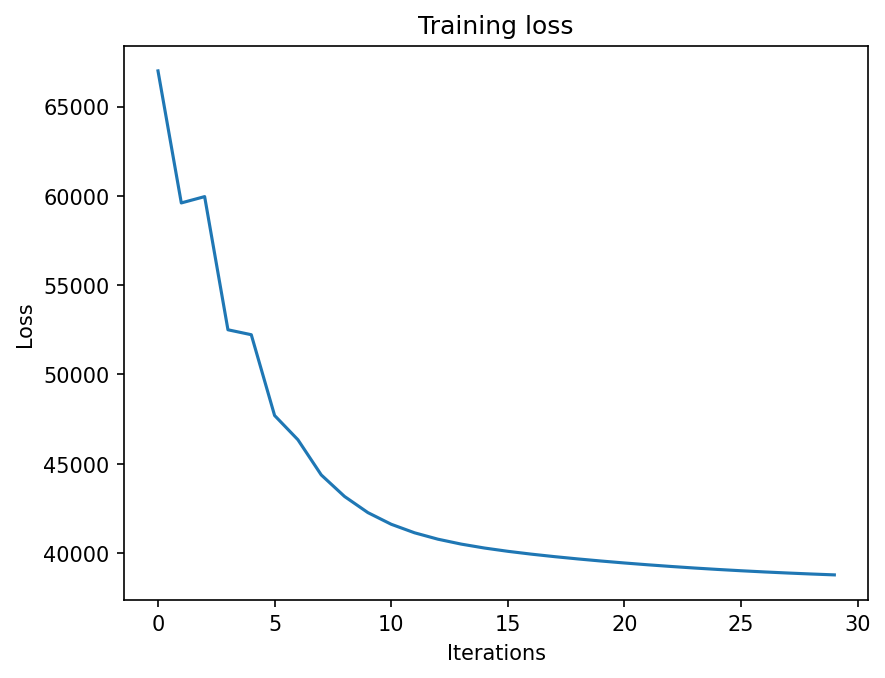

RMSE (mean) on model  HadGEM3-GC31-LL  :  1.429410514367
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration 

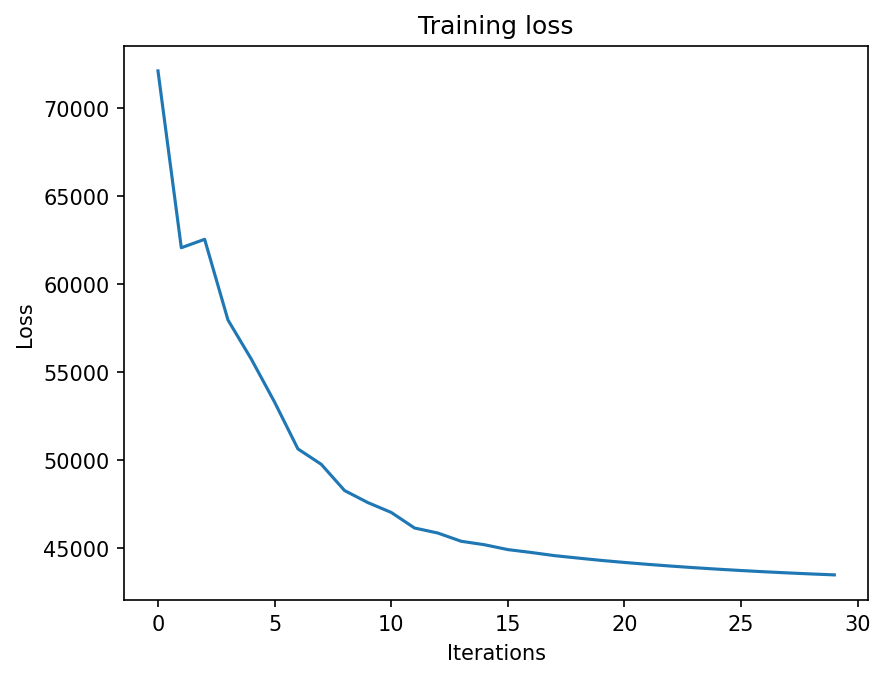

RMSE (mean) on model  MIROC6  :  0.10267753420615923
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.16015625
Iteration  10 : Loss function :  47020.94921875
Iteration  11 : Loss function :  46134.01953125
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.671875
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.43359375
Iteration  16 : Loss function :  44743.01953125
Iteration  17 : Loss function :  44562.96484375
Iteration  18 : Loss function :  44425.6953125
Iteration  19 : Loss function :  44291.71875
Iteration  

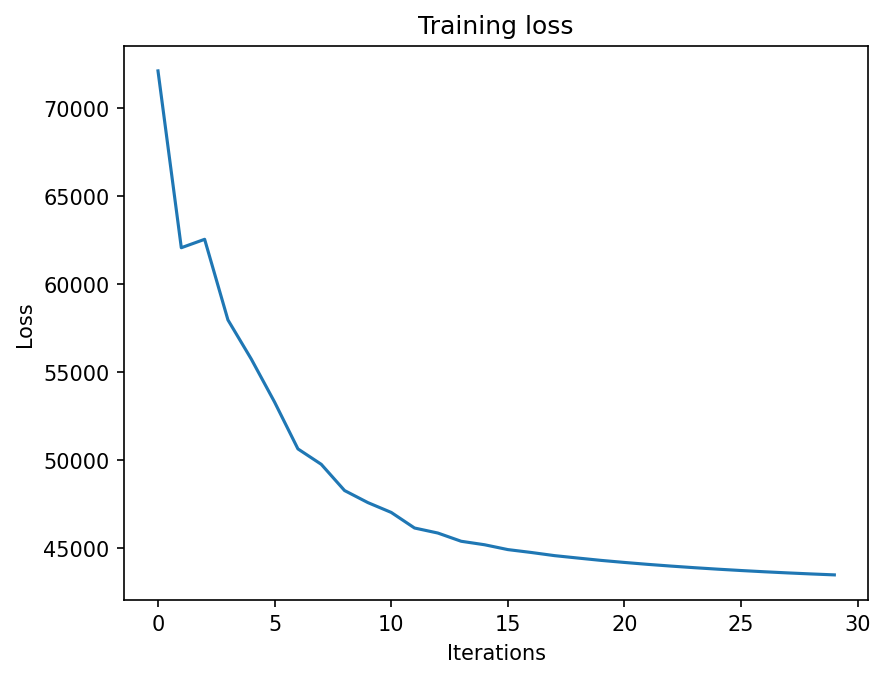

RMSE (mean) on model  CESM2  :  0.7774603229120042
Iteration  0 : Loss function :  61742.6796875
Iteration  1 : Loss function :  57235.81640625
Iteration  2 : Loss function :  55100.890625
Iteration  3 : Loss function :  50643.58984375
Iteration  4 : Loss function :  49125.15625
Iteration  5 : Loss function :  45646.7265625
Iteration  6 : Loss function :  44292.421875
Iteration  7 : Loss function :  42482.984375
Iteration  8 : Loss function :  41378.95703125
Iteration  9 : Loss function :  40604.90234375
Iteration  10 : Loss function :  40038.04296875
Iteration  11 : Loss function :  39615.1875
Iteration  12 : Loss function :  39287.36328125
Iteration  13 : Loss function :  39023.82421875
Iteration  14 : Loss function :  38805.9140625
Iteration  15 : Loss function :  38622.6875
Iteration  16 : Loss function :  38458.73046875
Iteration  17 : Loss function :  38332.62109375
Iteration  18 : Loss function :  38180.37890625
Iteration  19 : Loss function :  38093.74609375
Iteration  20 : Los

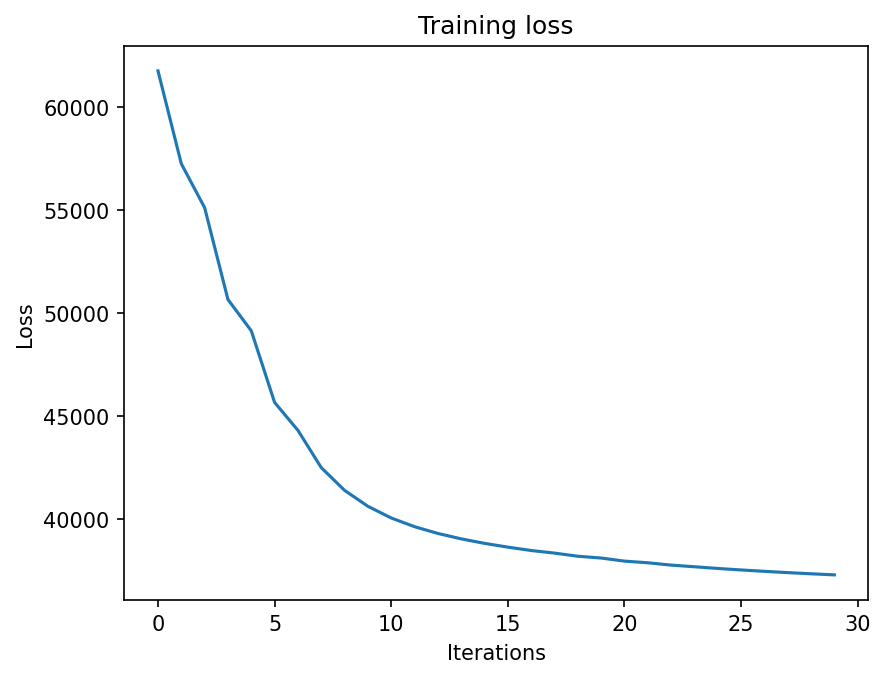

RMSE (mean) on model  FGOALS-g3  :  1.6015339206439685
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration  2

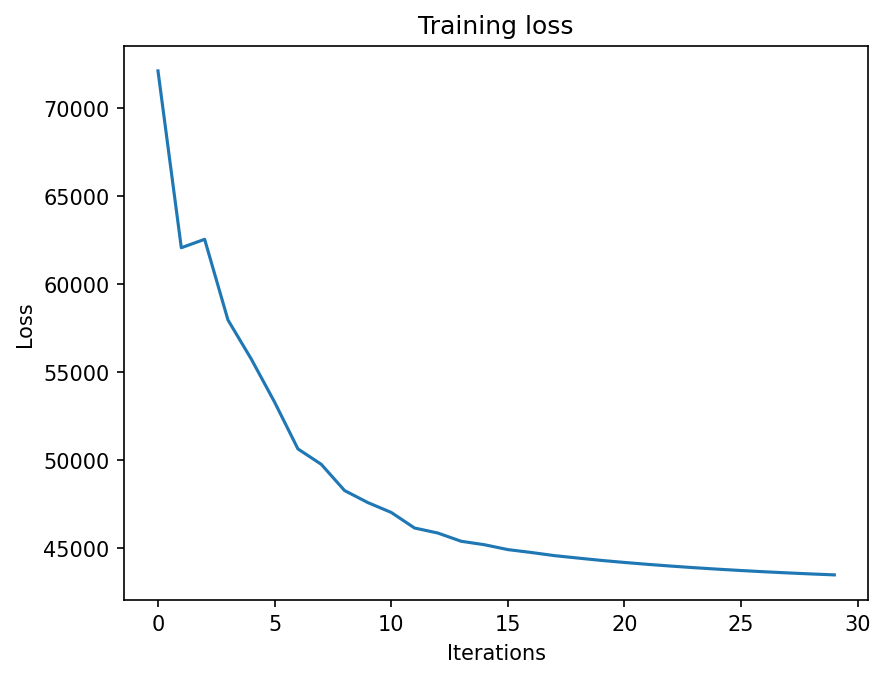

RMSE (mean) on model  GISS-E2-1-G  :  0.36168169352579405
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration

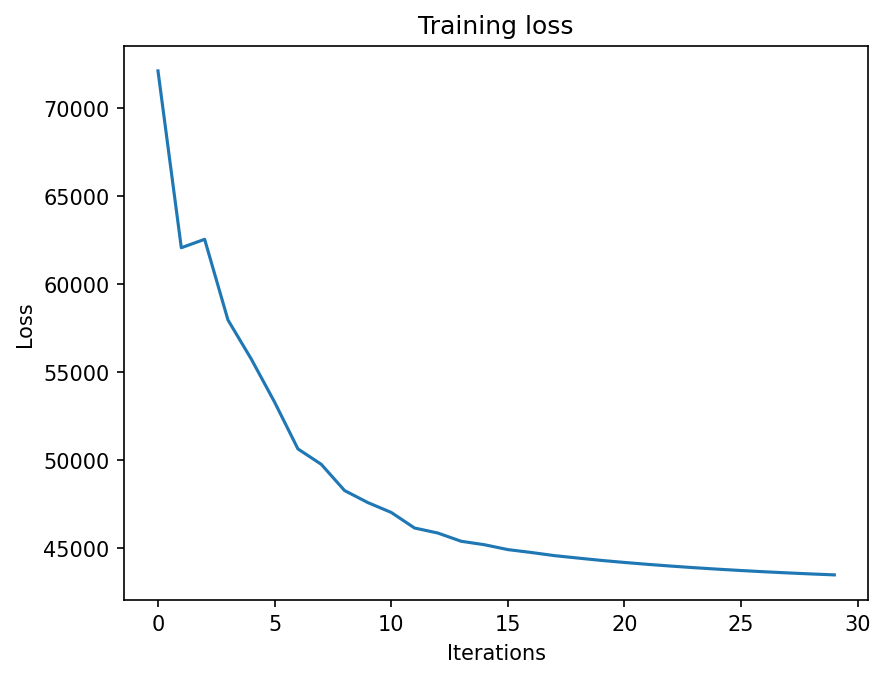

RMSE (mean) on model  MRI-ESM2-0  :  0.4622989001705243
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration  

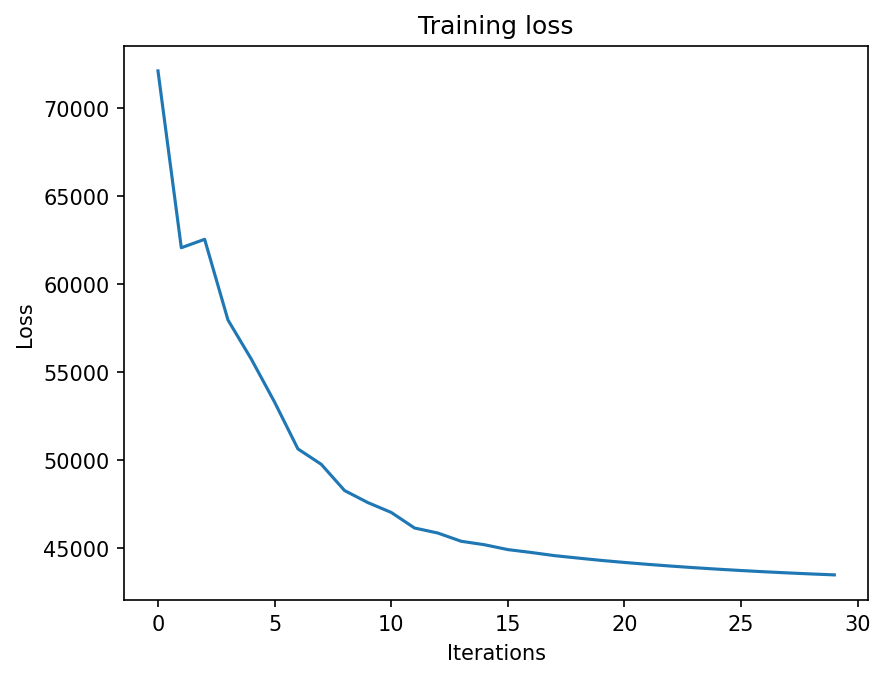

RMSE (mean) on model  ACCESS-ESM1-5  :  0.11911702731083774
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iterati

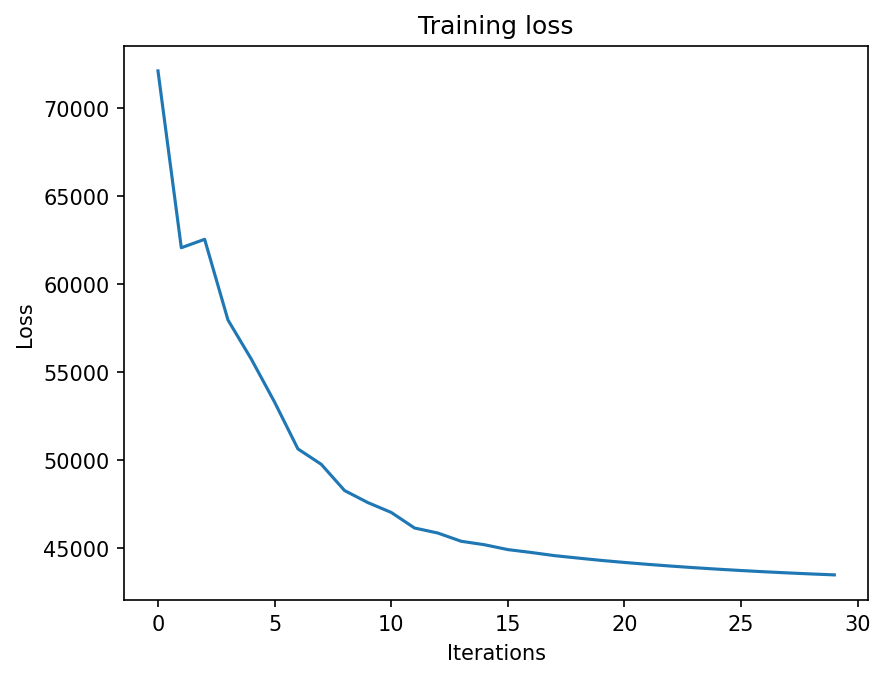

RMSE (mean) on model  IPSL-CM6A-LR  :  0.3759029473624139
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration

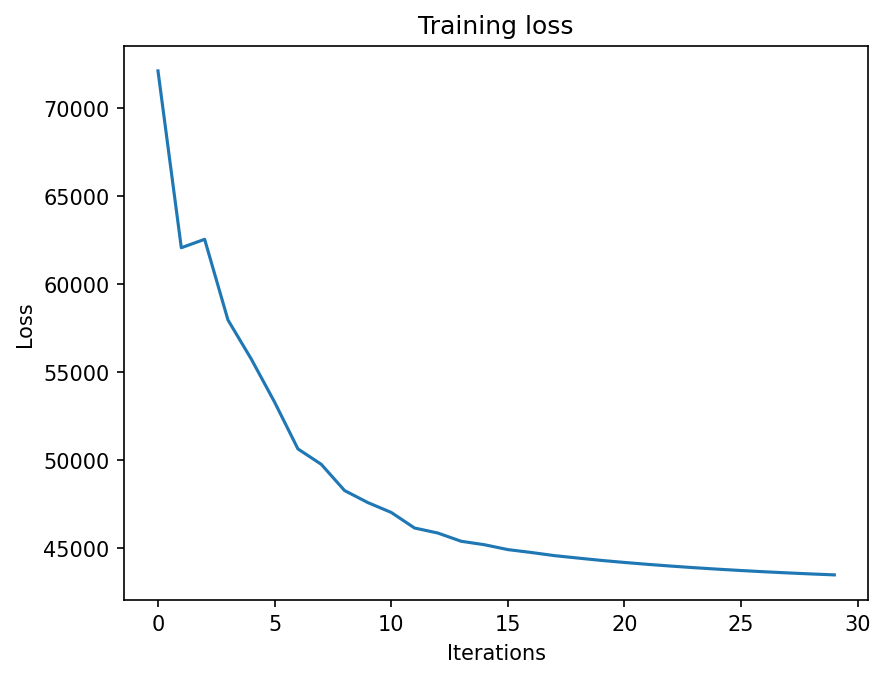

RMSE (mean) on model  CanESM5  :  0.15994710146483943
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration  20

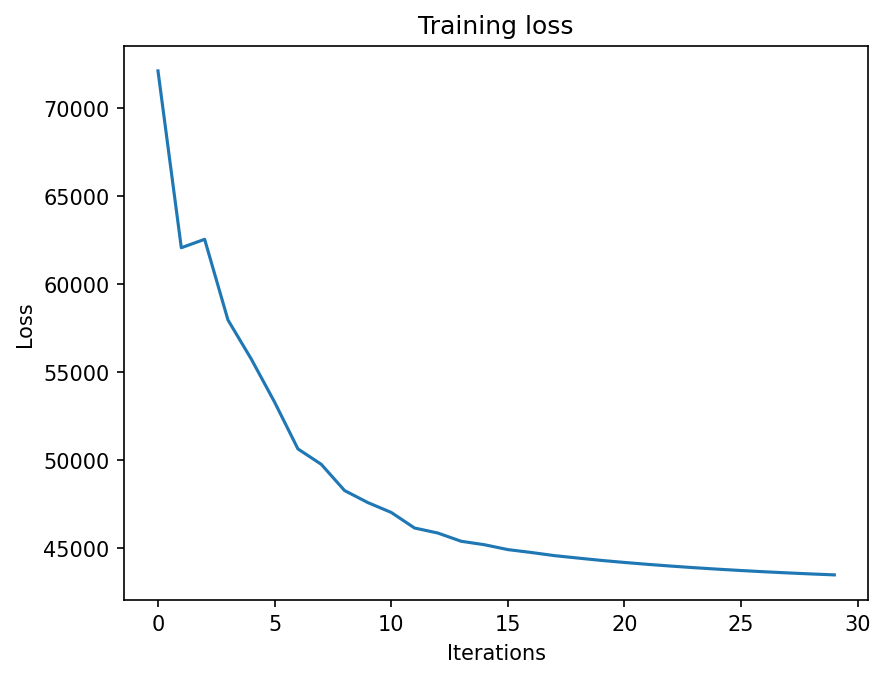

RMSE (mean) on model  ACCESS-CM2  :  0.2776701022770856
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.62109375
Iteration  7 : Loss function :  49758.20703125
Iteration  8 : Loss function :  48265.2734375
Iteration  9 : Loss function :  47579.1640625
Iteration  10 : Loss function :  47020.9453125
Iteration  11 : Loss function :  46134.0234375
Iteration  12 : Loss function :  45847.87109375
Iteration  13 : Loss function :  45379.67578125
Iteration  14 : Loss function :  45181.984375
Iteration  15 : Loss function :  44906.44140625
Iteration  16 : Loss function :  44743.03125
Iteration  17 : Loss function :  44562.98046875
Iteration  18 : Loss function :  44425.71875
Iteration  19 : Loss function :  44291.74609375
Iteration  

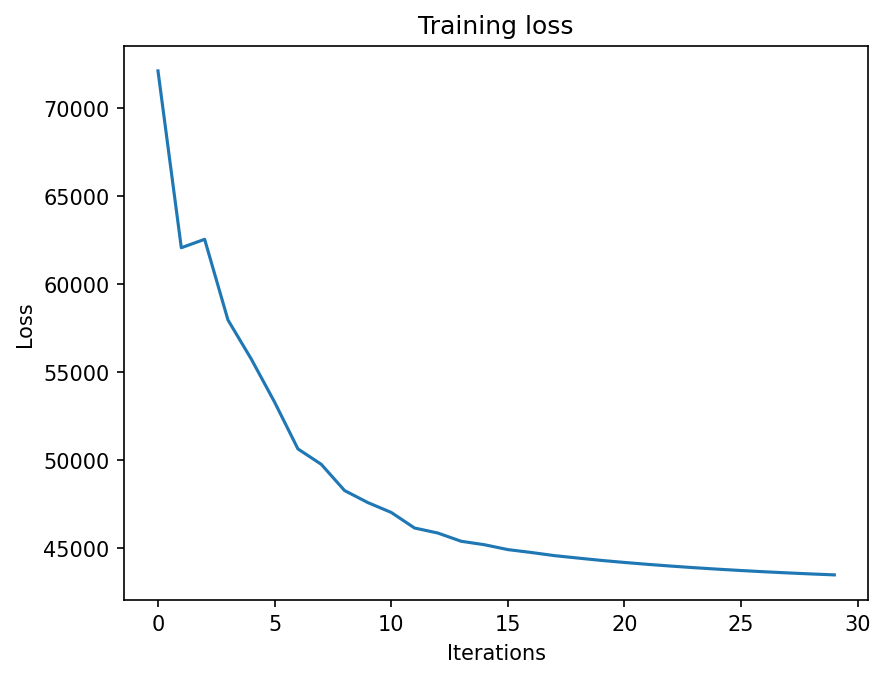

RMSE (mean) on model  MPI-ESM1-2-LR  :  0.11589707695287507
Iteration  0 : Loss function :  72139.7890625
Iteration  1 : Loss function :  62079.234375
Iteration  2 : Loss function :  62558.04296875
Iteration  3 : Loss function :  57970.2109375
Iteration  4 : Loss function :  55745.3515625
Iteration  5 : Loss function :  53295.23046875
Iteration  6 : Loss function :  50634.6171875
Iteration  7 : Loss function :  49758.19921875
Iteration  8 : Loss function :  48265.23046875
Iteration  9 : Loss function :  47579.07421875
Iteration  10 : Loss function :  47020.82421875
Iteration  11 : Loss function :  46133.42578125
Iteration  12 : Loss function :  45847.234375
Iteration  13 : Loss function :  45378.12890625
Iteration  14 : Loss function :  45180.3046875
Iteration  15 : Loss function :  44903.38671875
Iteration  16 : Loss function :  44739.421875
Iteration  17 : Loss function :  44557.74609375
Iteration  18 : Loss function :  44419.43359375
Iteration  19 : Loss function :  44283.72265625
I

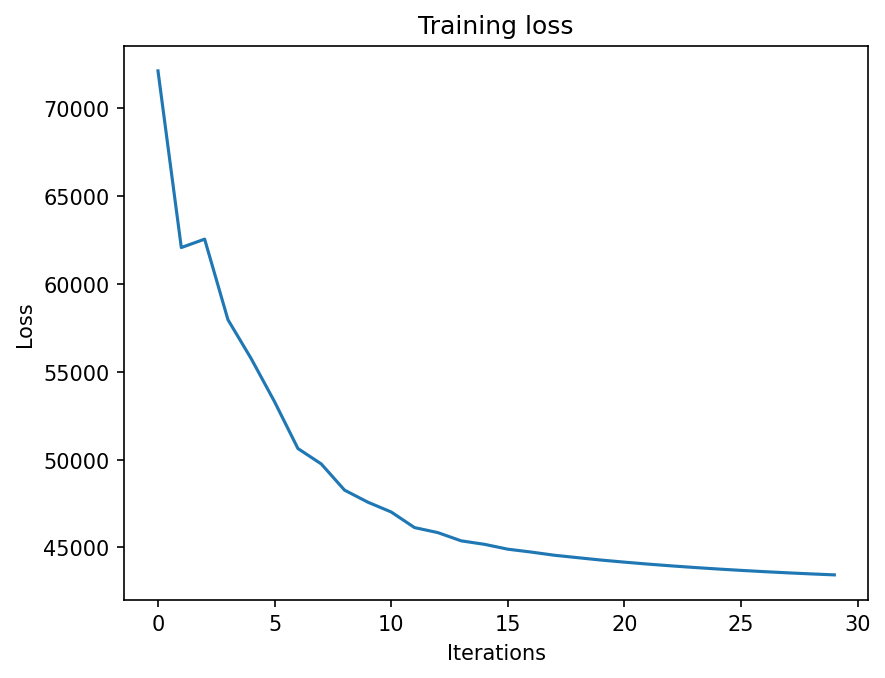

RMSE (mean) on model  UKESM1-0-LL  :  0.9023294935333825
Check that sum of weights ==1 :  tensor(1.0000)


/tmp/ipykernel_12120/1818005261.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


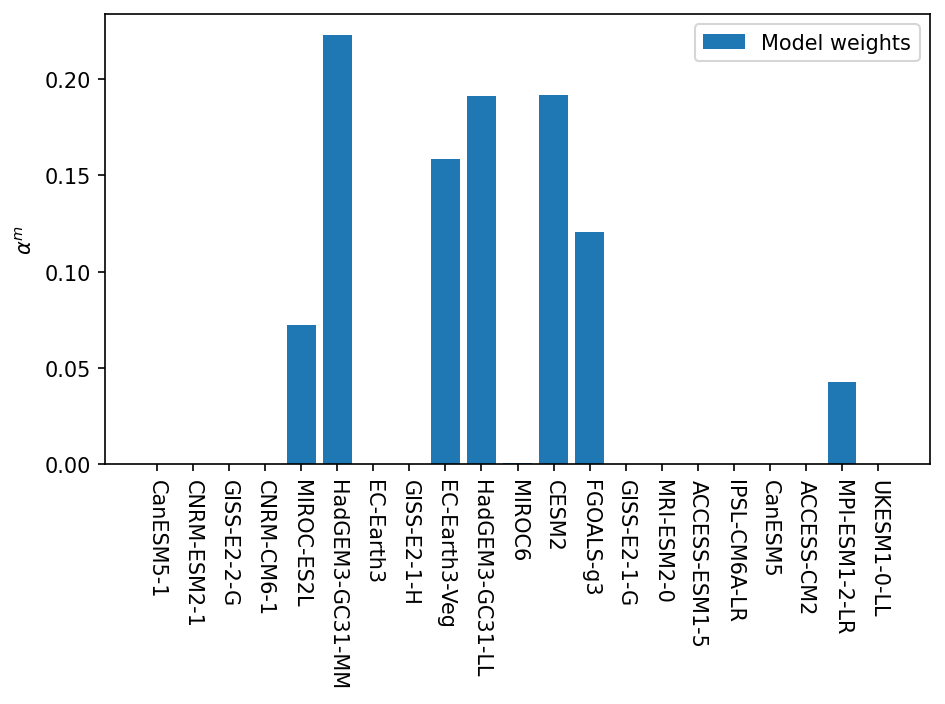

/tmp/ipykernel_12120/1818005261.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


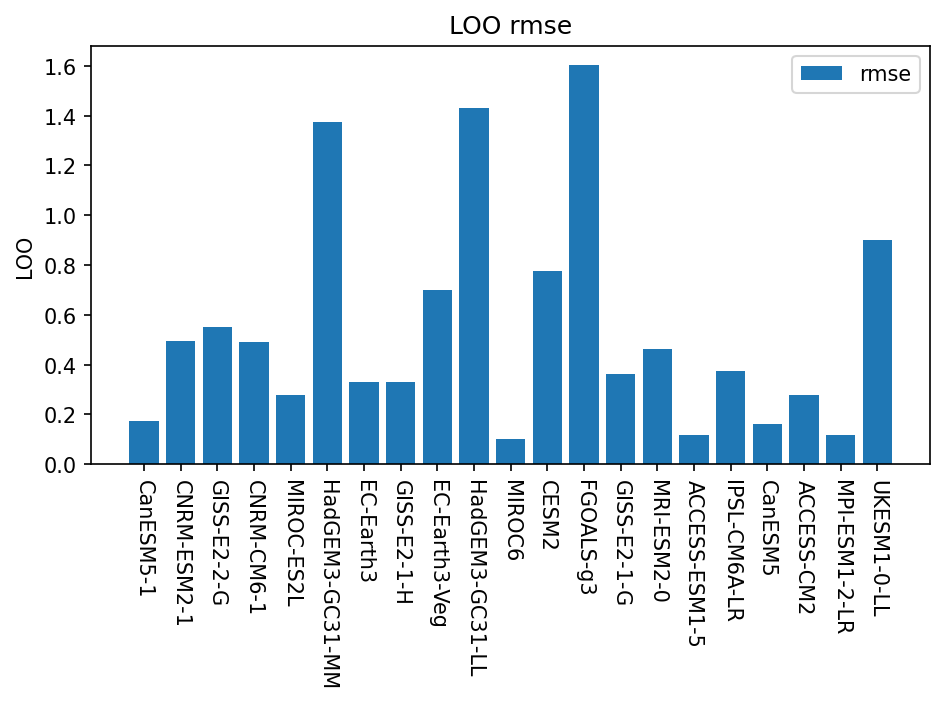

In [34]:
W_robust_rrr, rmse_mean_robust_rrr, training_loss_robust_rrr, weights_robust_rrr = leave_one_out_procedure(x,y,vars,\
                                                            lon_size,lat_size,notnan_idx,\
                                                            lr=0.0000001,nb_gradient_iterations=30, time_period=33,\
                                                            rank=rank_tmp,lambda_=lambda_tmp,method='robust',mu_=mu_tmp,verbose=True)

In [35]:
################### Ridge regresssion ########################
# compute the ridge loo
rmse_ridge_tmp =  np.array(list(rmse_mean_ridge.values()))

# worst loo Ridge
worst_loo_ridge = np.max(rmse_ridge_tmp)
mean_loo_ridge = np.mean(rmse_ridge_tmp)


# quantile 95, 90, 75
q_loo_95_ridge = np.quantile(rmse_ridge_tmp, 0.95)
q_loo_90_ridge = np.quantile(rmse_ridge_tmp, 0.90)
q_loo_75_ridge = np.quantile(rmse_ridge_tmp, 0.75)
q_loo_50_ridge = np.quantile(rmse_ridge_tmp, 0.5)


######################## compute the ridge rrr ######################
rmse_rrr_tmp =  np.array(list(rmse_mean_rrr.values()))

# worst loo Ridge
worst_loo_rrr = np.max(rmse_rrr_tmp)
mean_loo_rrr = np.mean(rmse_rrr_tmp)


# quantile 95, 90, 75
q_loo_95_rrr = np.quantile(rmse_rrr_tmp, 0.95)
q_loo_90_rrr = np.quantile(rmse_rrr_tmp, 0.90)
q_loo_75_rrr = np.quantile(rmse_rrr_tmp, 0.75)
q_loo_50_rrr = np.quantile(rmse_rrr_tmp, 0.5)


######################## compute the robust regression ######################
rmse_robust_tmp =  np.array(list(rmse_mean_robust.values()))

# worst loo Ridge
worst_loo_robust = np.max(rmse_robust_tmp)
mean_loo_robust = np.mean(rmse_robust_tmp)


# quantile 95, 90, 75
q_loo_95_robust = np.quantile(rmse_robust_tmp, 0.95)
q_loo_90_robust = np.quantile(rmse_robust_tmp, 0.90)
q_loo_75_robust = np.quantile(rmse_robust_tmp, 0.75)
q_loo_50_robust = np.quantile(rmse_robust_tmp, 0.5)

######################## compute the robust regression with low rank constraint ######################
rmse_robust_rrr =  np.array(list(rmse_mean_robust_rrr.values()))

# worst loo Ridge
worst_loo_robust_rrr = np.max(rmse_robust_rrr)
mean_loo_robust_rrr = np.mean(rmse_robust_rrr)


# quantile 95, 90, 75
q_loo_95_robust_rrr = np.quantile(rmse_robust_rrr, 0.95)
q_loo_90_robust_rrr = np.quantile(rmse_robust_rrr, 0.90)
q_loo_75_robust_rrr = np.quantile(rmse_robust_rrr, 0.75)
q_loo_50_robust_rrr = np.quantile(rmse_robust_rrr, 0.5)


print("======= Statistics ========")
print("\n")
print("          Ridge   RR-Lr   Robust  Robust-Lr")
print("Worst:    {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(worst_loo_ridge,worst_loo_rrr,worst_loo_robust, worst_loo_robust_rrr))
print("0.95:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_95_ridge,q_loo_95_rrr,q_loo_95_robust, q_loo_95_robust_rrr))
print("0.90:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_90_ridge,q_loo_90_rrr,q_loo_90_robust, q_loo_90_robust_rrr))
print("0.75:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_75_ridge,q_loo_75_rrr,q_loo_75_robust, q_loo_75_robust_rrr))
print("Median:   {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_50_ridge,q_loo_50_rrr,q_loo_50_robust, q_loo_50_robust_rrr))
print("Mean:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(mean_loo_ridge,mean_loo_rrr,mean_loo_robust, mean_loo_robust_rrr))

======= Statistics ========


          Ridge   RR-Lr   Robust  Robust-Lr
Worst:    1.633   1.773   1.329   1.602
0.95:     1.438   1.540   1.183   1.429
0.90:     1.420   1.489   1.142   1.375
0.75:     0.607   0.681   0.572   0.702
Median:   0.332   0.357   0.367   0.376
Mean:     0.511   0.542   0.478   0.544


#### Display the weights

In [38]:
weights_robust_tmp = torch.zeros(len(x.keys()))
weights_robust_lr_tmp = torch.zeros(len(x.keys()))

for idx_m, m in enumerate(x.keys()):
    weights_robust_tmp +=  torch.tensor(list(weights_robust[m].values()))
    weights_robust_lr_tmp += torch.tensor(list(weights_robust_rrr[m].values()))

weights_robust_tmp = weights_robust_tmp / (len(x.keys()))
weights_robust_lr_tmp = weights_robust_lr_tmp / (len(x.keys()))

/tmp/ipykernel_12120/1971038463.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


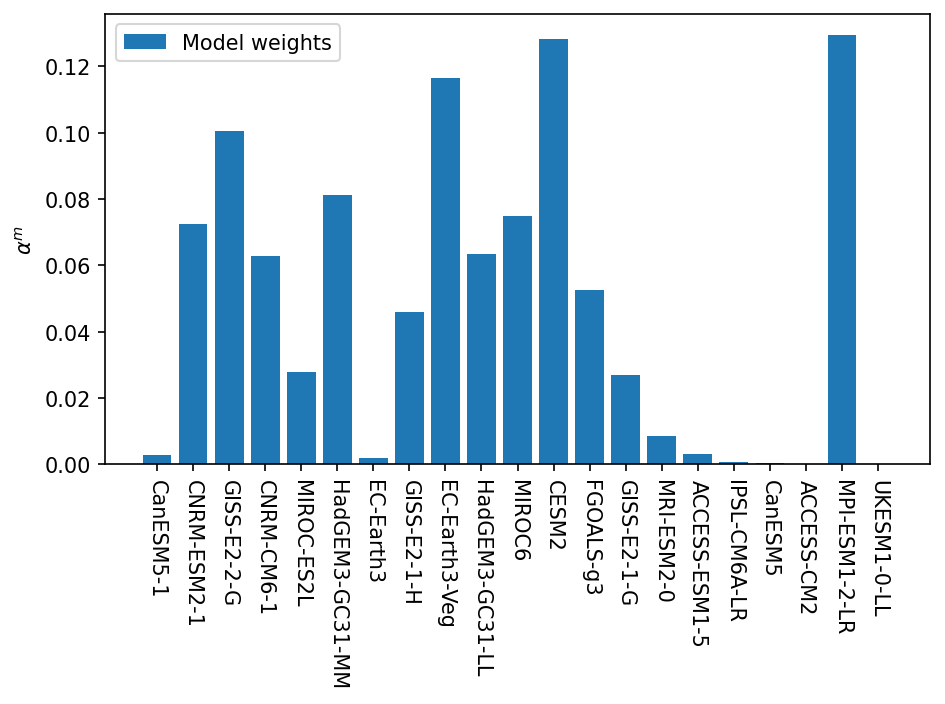

/tmp/ipykernel_12120/1971038463.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


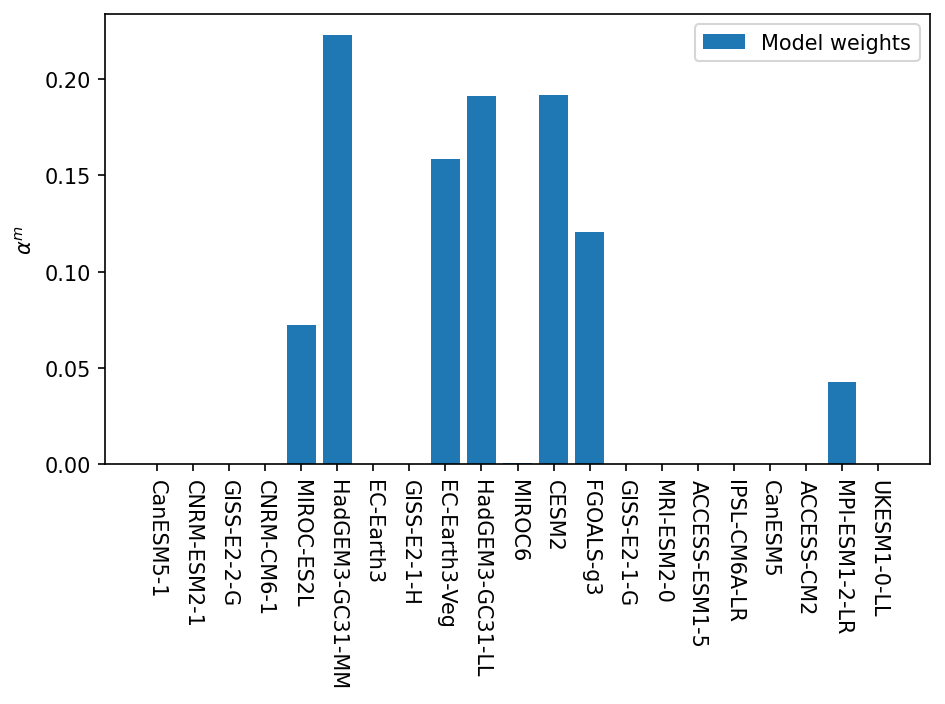

In [41]:
plt.close("all")

################# plot the rmse #################
fig, ax = plt.subplots()
ax.bar(list(x.keys()), weights_robust_tmp,label='Model weights')
ax.set_ylabel(r'$\alpha^m$')
ax.legend()
ax.set_xticklabels(list(x.keys()), rotation=-90)
plt.tight_layout()
# plt.savefig("results/weights_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
plt.show()

fig, ax = plt.subplots()
ax.bar(list(x.keys()), weights_robust_lr_tmp,label='Model weights')
ax.set_ylabel(r'$\alpha^m$')
ax.legend()
ax.set_xticklabels(list(x.keys()), rotation=-90)
plt.tight_layout()
# plt.savefig("results/weights_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
plt.show()

# Train the model using Pytorch autograd

In [ ]:
def train_robust_model(x,y,lon_size,lat_size,models,lambda_=1.0,mu_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - mu_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    w = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
    w.requires_grad_(True)  

    # define optimizer
    optimizer = torch.optim.SGD([w],lr=1e-5)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0
    training_loss = torch.zeros(nbEpochs)
    
            
    # --- optimization loop ---                
    while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
        res = torch.zeros(len(models))

        for idx_m, m in enumerate(models):  
            for idx_r, r in enumerate(x_predictor[m].keys()):
                res[idx_m] += torch.sum((y[m][idx_r*time_period:(idx_r+1)*time_period,notnan_idx] -x[m][idx_r*time_period:(idx_r+1)*time_period,notnan_idx] @ w[notnan_idx,:][:,notnan_idx] )**2)
                
            res[idx_m] = res[idx_m]/len(x_predictor[m].keys())
            
        obj = mu_*torch.logsumexp((1/mu_)* res,0)
        obj += lambda_*torch.norm(w,p='fro')**2
                    
        #define loss function
        loss = obj

        # set the training loss
        training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward()               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step() 


        if(verbose==True):
            if(epoch % 2 == 0):
                print('Epoch ', epoch, 
                        ', loss=', training_loss[epoch].detach().item()
                        )
        criteria = loss
        epoch +=1
    
    plt.figure()
    plt.plot(range(nbEpochs),training_loss)
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('iterations')
    plt.show()


    ############ HERE ####################
    # # compute the alphas of the robust model
    # M = len(x.keys())
    # alpha = torch.zeros(M)
    # res = torch.zeros(M,33)
    
    # # compute the training loss for each model
    # model_loss = torch.zeros(M)
    
    # for idx_m,m in enumerate(x.keys()):
    #     for idx_i, i in enumerate(x[m].keys()):
    #         res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
            
    #     res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
    #     alpha[idx_m] = (1/mu_)*torch.mean(res[idx_m,:],axis=0)
    #     model_loss[idx_m] = torch.mean(res[idx_m,:])
    
    # alpha = torch.nn.functional.softmax(alpha)
    
    return w

In [ ]:
W = train_robust_model(x_train,y_train,lon_size,lat_size,training_models,lambda_=100.0,mu_=1.0,nbEpochs=50,verbose=True)

In [ ]:
W

In [ ]:
y_pred = torch.ones_like(x_test).to(torch.float64)
y_pred[:,nan_idx] = float('nan')
y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W[notnan_idx,:][:,notnan_idx].to(torch.float64)

y_target = y_test[:time_period,:]
y_target_pred = y_pred[:time_period,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


plt.close('all')
fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 2, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

In [ ]:
torch.nanmean((y_target - y_target_pred)**2)

In [ ]:
from matplotlib import animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure()

ax0 = fig0.add_subplot(1, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 2, 2)        
ax1.set_title(r'Robust reduced rank regression ', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[0,:].detach().numpy().reshape(lat_size,lon_size)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred = y_target_pred[i,:].detach().numpy().reshape(lat_size,lon_size)

    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.tight_layout()
animation.FuncAnimation(fig0, animate_maps, frames=time_period)